<h1><center>Polio cases analysis and predictions</center></h1>
Authors:<br>
- Filip Olszowski, 302891<br>
- Szymon Lis, 302871 

<h3>Introduction</h3>
<div style="  text-align: justify; text-justify: inter-word;">
Data analysis for given set of measurements can be very helpful to understand certain phenomenons from found correlations. However, another use of statistic modeling is to create a model from given samples and make predictions from it. In our project, we created two models with the same parameters to compare differences and see how different approaches lead to different results. 
Topic of our project is Polio disease, specifically paralysis cases. We will make predictions for three diferent time slots to see how models behave with different sets of data<br>

<b>Polio descripion:</b><br>
Poliomyelitis commonly shortened to polio, is an infectious disease caused by the poliovirus. In about 0.5 percent of cases, it moves from the gut to affect the central nervous system, and there is muscle weakness resulting in a flaccid paralysis. This can occur over a few hours to a few days. The weakness most often involves the legs, but may less commonly involve the muscles of the head, neck, and diaphragm. Many people fully recover. In those with muscle weakness, about 2 to 5 percent of children and 15 to 30 percent of adults die. Up to 70 percent of those infected have no symptoms. Another 25 percent of people have minor symptoms such as fever and a sore throat, and up to 5 percent have headache, neck stiffness, and pains in the arms and legs. These people are usually back to normal within one or two weeks. Years after recovery, post-polio syndrome may occur, with a slow development of muscle weakness similar to that which the person had during the initial infection.
<h6>Source: https://en.wikipedia.org/wiki/Polio </h6>
</div>

<h3>Prepared Models</h3>

In order to analyse given data, two models were prepared:
1. Autoregressive model
2. Linear regression model

<b>Autoregressive model:</b><br>
A first-order autoregressive model (called AR(1)) were mainly used for analysis as it is generating data from previous set of points, so can be useful for preparing models for disease analysis. The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term, thus renders itself ideal for given task of disease modelling.<br>
Model is given by formula:

$$
y_n = normal(\alpha + \beta*y_{n-1}, \sigma)
$$

<h6>Reference: https://mc-stan.org/docs/2_23/stan-users-guide/autoregressive-section.html</h6>
<b>Linear regression model:</b><br>
Linear regression is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables. In our task to model disease moddeling linear regression model will certanly be behaving worse as there is no correlation between years and cases of disease except passing time. Hoever it is great tool to compare two approaches to moddeling of this phenomena. <br>
Model is given by formula:

$$
y = normal(\alpha + x*\beta, \sigma)
$$


In order to simulate next year in disease evolution formulas above will be slighty modified. <br>
In autoregressive model, data will be predicted from the last point, so:

$$
y_{pred} = normal(\alpha + \beta*y_{N}, \sigma)
$$

where N is lenght of given data.<br>
And linear regression model will use standard equation to simulate the next year.

$$
y_{pred} = normal(\alpha + x_{pred}*\beta, \sigma)
$$

where x_pred is year given for prediction.<br> 
In our case both poins are set to be 2021.

<h3>Scenarios</h3>
Prepared models will be testes for three different scenarios:<br>
 1. Whole data<br>
 2. Last decade (due to U-shape data)<br>
 3. Last 5 years (due to only growths in numers)<br>

With these data, different reactions and predictions can be observed and analyzed in order to conclude whether the model is behaving correctly or not. 

<h4>Imports:</h4>

In [1]:
from cmdstanpy import CmdStanModel, CmdStanMCMC
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

global_seed = 29042020

<h4>Used functions</h4>

In [2]:
def select_data(country: str, n_last_years: int = None) -> pd.DataFrame:
    import_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
    selected_data = {}
    if n_last_years:
        selected_data['Cases'] = import_data[import_data['Entity'] == country][['Total (reported) polio cases']][-n_last_years-1:-1].to_numpy().flatten()
        selected_data['Year'] = import_data[import_data['Entity'] == country][['Year']][-n_last_years-1:-1].to_numpy().flatten()
    else:
        selected_data['Cases'] = import_data[import_data['Entity'] == country][['Total (reported) polio cases']][:-1].to_numpy().flatten()
        selected_data['Year'] = import_data[import_data['Entity'] == country][['Year']][:-1].to_numpy().flatten()
    return selected_data

def plot_selected_data(selected_data: pd.DataFrame) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.legend(['Total (reported) polio cases for selected data'], prop={'size': 20})
    plt.xlabel('Year')
    plt.ylabel('Number of cases')
    plt.title(f'Data for the last {len(selected_data["Year"])} years')
    plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
    plt.show()
    
def plot_distributions(fitted_model: CmdStanMCMC) -> None:
    plt.figure(figsize=(26, 6))
    plt.grid(True)
    plt.subplot(131)
    plt.hist(fitted_model.stan_variable('alpha'), bins = 30, density = True)
    plt.title('Alpha distribution')
    plt.subplot(132)
    plt.hist(fitted_model.stan_variable('beta'), bins = 30, density = True)
    plt.title('Beta distribution')
    plt.subplot(133)
    plt.hist(fitted_model.stan_variable('sigma'), bins = 30, density = True)
    plt.title('Sigma distribution')
    plt.show()
    
def plot_predictions_chart(selected_data: pd.DataFrame, pred_variable: np.ndarray, pred_year: int|str, type: str ,quantiles: bool = True) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.plot([pred_year-1, pred_year], [selected_data['Cases'][-1], int(np.mean(pred_variable))], linewidth=5)
    if quantiles:
        plt.scatter(pred_year,np.quantile(pred_variable,0.95), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.75), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.5), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.25), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.05), linewidth=0.5)
        plt.legend(['Total polio cases [imported data]','Mean of predicted polio cases', 'Quantile 0.95', 'Quantile 0.75','Quantile 0.5','Quantile 0.25','Quantile 0.05'], prop={'size': 20})
    else:
        plt.legend(['Total polio cases [imported data]','Mean of predicted polio cases'], prop={'size': 20})
    plt.title(f'Model chart with predicted data using {type} model')
    plt.show()
    print(f'[{type}] Predicted mean value of Polio cases for year {pred_year}: {int(np.mean(pred_variable))}')
    

<h3>Importing world data</h3>

Imported data is in CSV format, and we extracted data of our interest to pandas dataframe

Source: https://ourworldindata.org/polio 

In [3]:
imported_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
world_data = imported_data[imported_data['Entity'] == 'World'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]  #2021 data is incomplete
world_data.reset_index(inplace=True)
world_data.describe()

,index,Year,Total (reported) polio cases,Total (estimated) polio cases
count,41.000000,41.000000,41.000000,41.000000
mean,7642.000000,2000.000000,13153.390244,87584.902439
std,11.979149,11.979149,17926.259126,126481.340420
min,7622.000000,1980.000000,42.000000,49.000000
25%,7632.000000,1990.000000,784.000000,1139.000000
50%,7642.000000,2000.000000,2971.000000,20797.000000
75%,7652.000000,2010.000000,23053.000000,131538.000000
max,7662.000000,2020.000000,65737.000000,460159.000000


<h3>World trends</h3>

Looking at global data from the past 40 years it seems that polio was successfully stopped, hoever, closer inspection to the past few years is necessary to understand growing problem.

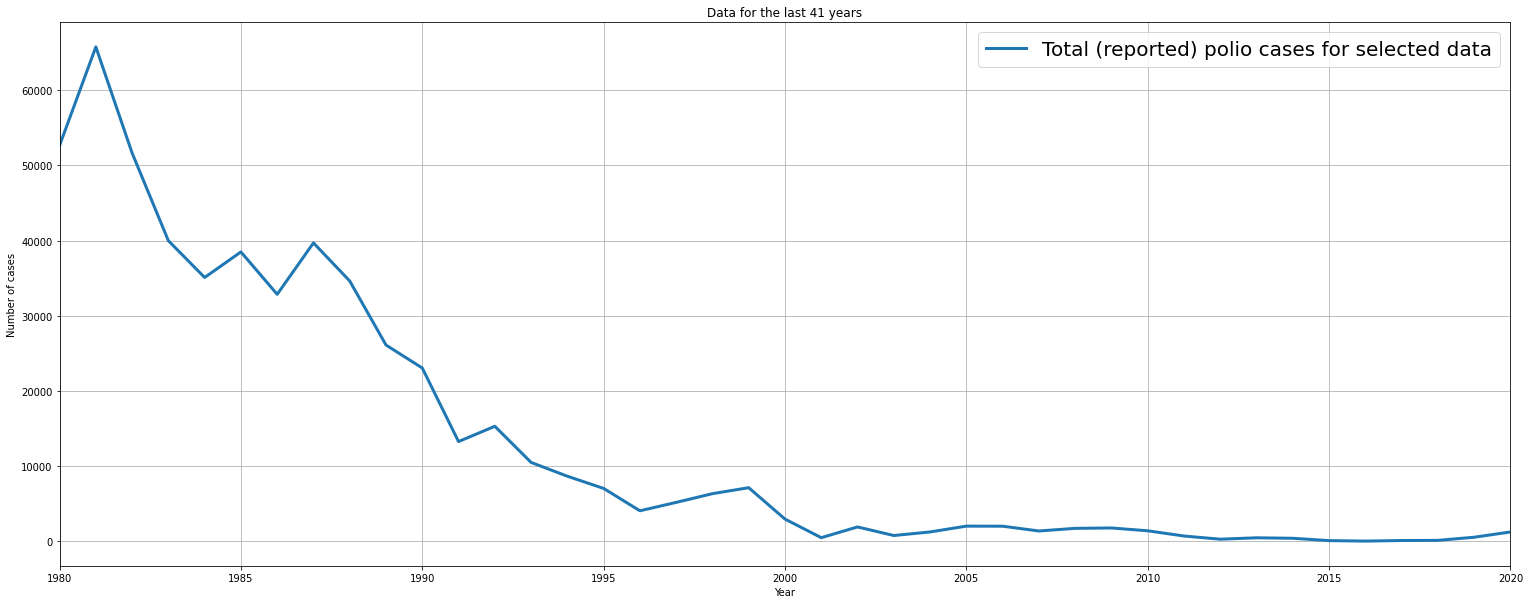

13153.390243902439


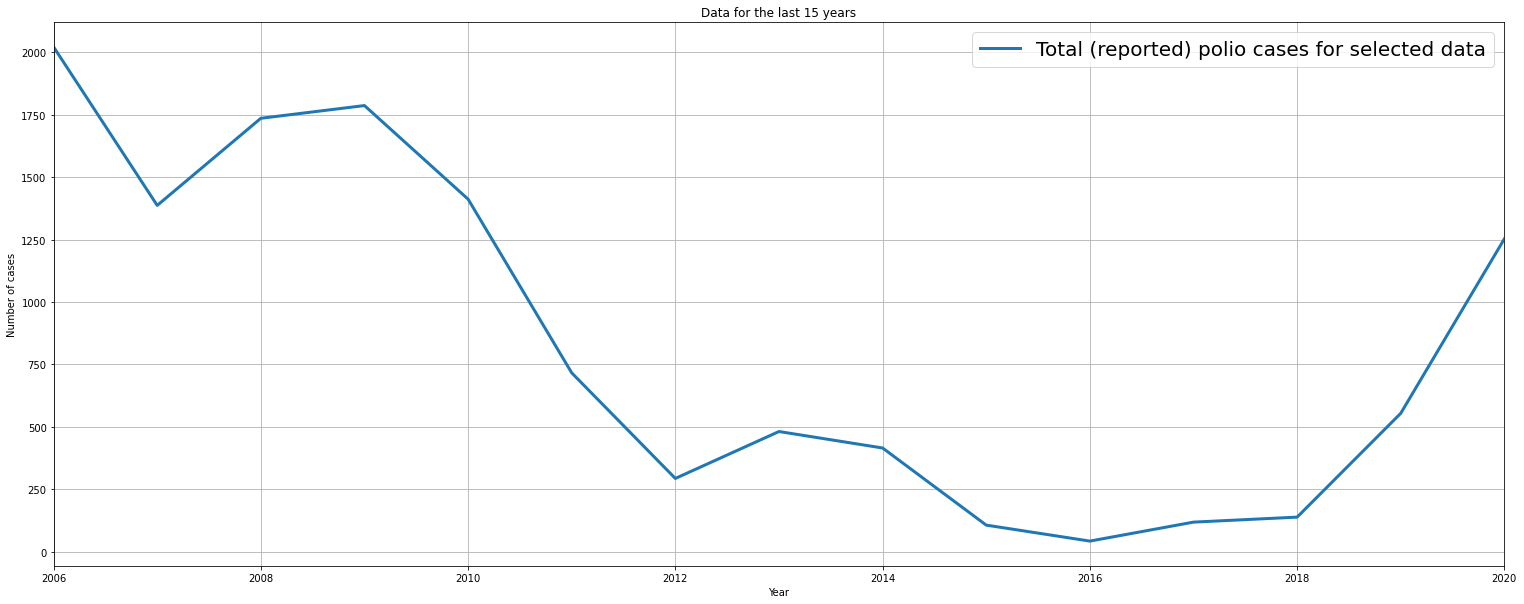

In [4]:
selected_world_data = select_data('World')
plot_selected_data(selected_world_data)

print(np.mean(selected_world_data['Cases']))

selected_world_data = select_data('World', 15)
plot_selected_data(selected_world_data)

As it can be seen in selected period of time, polio is growing rather than being eradicated 

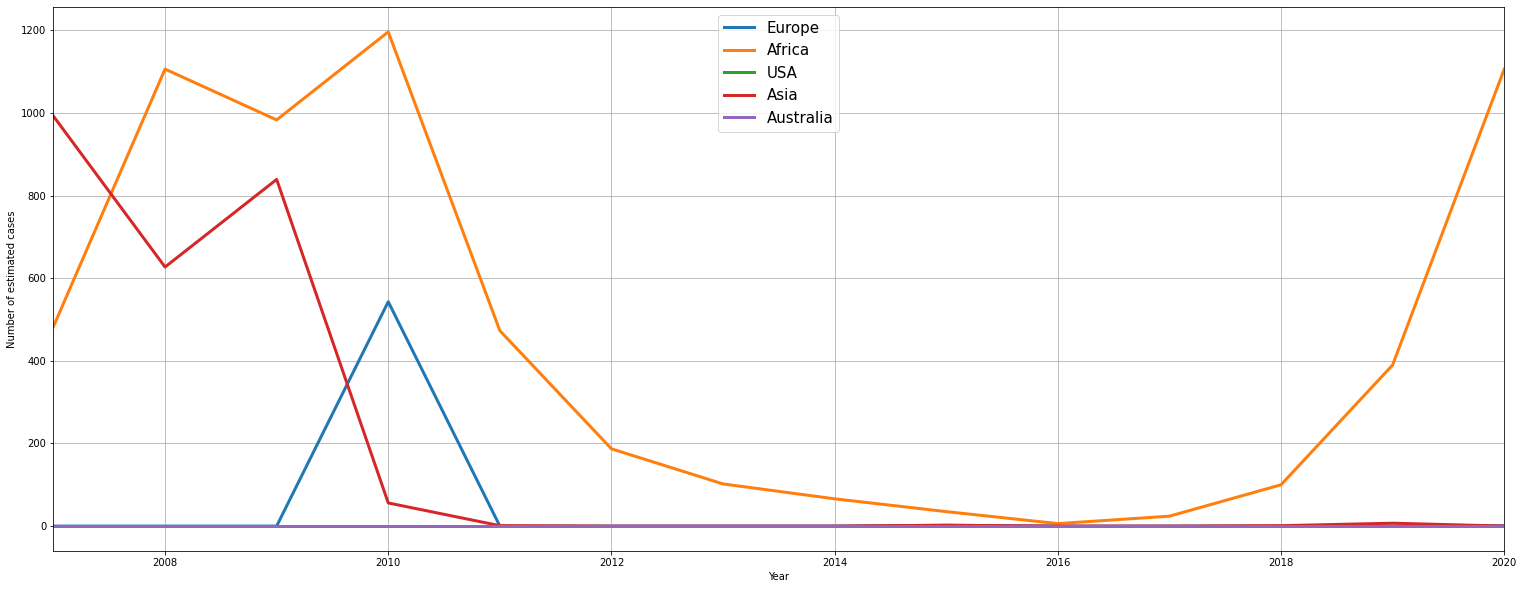

In [5]:
europe_selected_data = imported_data[imported_data['Entity'] == 'Europe'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
africa_selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
states_selected_data = imported_data[imported_data['Entity'] == 'United States'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
asia_selected_data = imported_data[imported_data['Entity'] == 'South-East Asia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
australia_selected_data = imported_data[imported_data['Entity'] == 'Australia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(europe_selected_data['Year'],europe_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(africa_selected_data['Year'],africa_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(states_selected_data['Year'],states_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(asia_selected_data['Year'],asia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(australia_selected_data['Year'],australia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Europe','Africa','USA','Asia','Australia'], prop={'size': 15})
plt.xlabel('Year')
plt.ylabel('Number of estimated cases')
plt.xlim(min(europe_selected_data['Year']),max(europe_selected_data['Year']))
plt.show()

In [6]:
imported_data[imported_data['Entity'] == 'Africa'][['Total (reported) polio cases','Total (estimated) polio cases']].describe()

,Total (reported) polio cases,Total (estimated) polio cases
count,42.000000,41.000000
mean,1621.357143,10349.926829
std,1490.099945,11358.507616
min,5.000000,6.000000
25%,406.500000,473.000000
50%,1042.000000,6937.000000
75%,2841.250000,20027.000000
max,5126.000000,35882.000000


As it can be seen, the problem is growing rapidly in Africa. So we will make predictions for Africa continent as it is currently most interesting to predict further development of paralytic cases of polio.

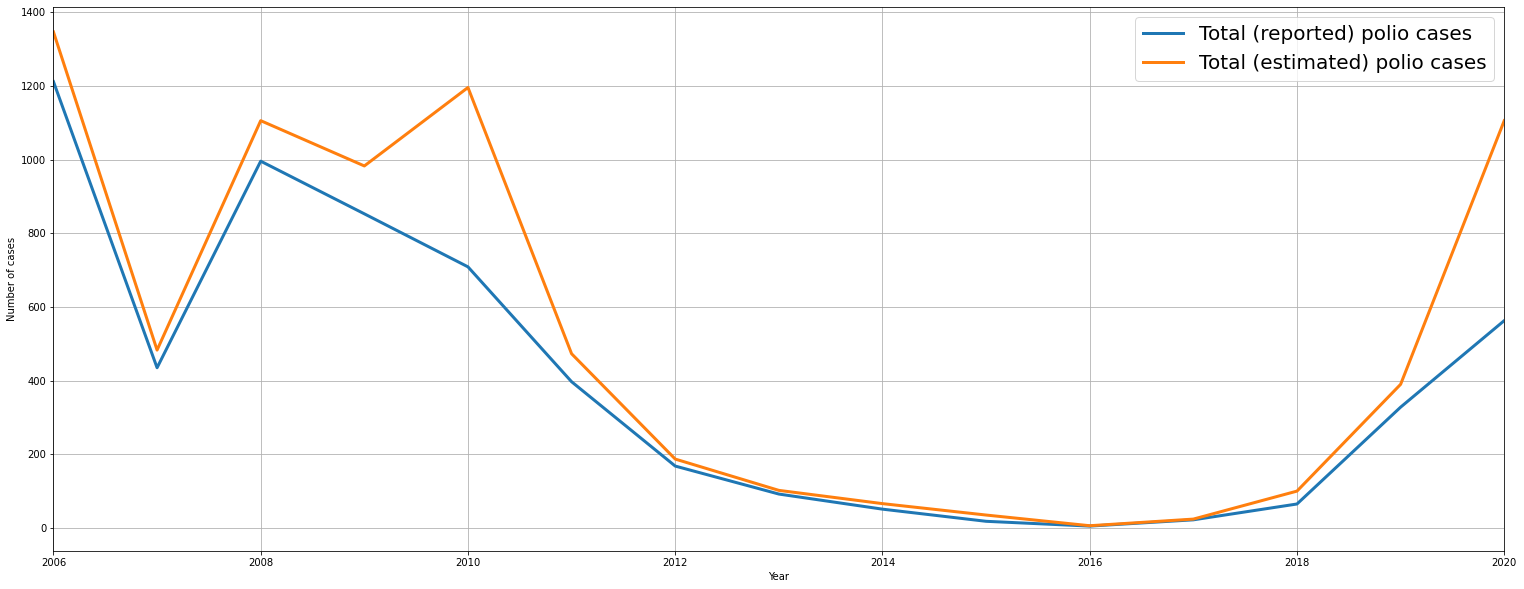

In [7]:
# Selecting data for analysis
n_years = 15
selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-n_years-1:-1]
selected_data.rename(columns = {'Total (reported) polio cases': 'Cases'}, inplace=True)
selected_data.rename(columns= {'Total (estimated) polio cases':'Cases_estimated'}, inplace=True)

plt.figure(figsize=(26, 10))
plt.grid(True)
plt.locator_params(axis="both", integer=True, tight=True)
plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
plt.plot(selected_data['Year'],selected_data['Cases_estimated'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
plt.show()

<h3>Prior predictive checks</h3>

In order to ensure models will be granted best possible results, prior checks must be implemented to verify whether alpha, beta and sigma are well fitted for our problem.<br>
For our values we picked as follows:
- alpha ~ normal(1600, 1500) 
- beta  ~ lognormal(0,1)       
- sigma ~ exponential(1)       

Alpha priors were selected from analysis from historic data mean and standard deviation of African data <br>
Beta to prevent negative cases <br>
Sigma to accommodate considerable uncertainty of disease spread, but keeping in mind that polio paralitic cases are not that frequent among infected.<br><br>
To verify supplied priors, simulated data will be compared to real data to ensure it is connected to eachother. <br>
To achieve that, autoregressive model were prepared, as it is fitted to task of generating data from previous set of points

In [8]:
stan_file = "stan_models\\autoregressive_sim.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
    int N;
    vector [N] y; // cases
}
parameters { 
  real alpha; 
  real beta;
  real <lower = 0> sigma; 
} 
transformed parameters {
  real mu[N];
  for (n in 2:N){
    mu[n] = alpha + beta * y[n-1];
  }
}
model{ 
  alpha ~ normal(1600, 1500);
  beta ~ lognormal(0,1);
  sigma ~ exponential(1);
  for (n in 2:N){
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
  }
}
generated quantities{ 
    real y_sim[N];
    for (n in 2:N){
        y_sim[n] = normal_rng(alpha + beta * y[n-1], sigma);
    }
    real log_lik[N-1];
    for(j in 2:N){
        log_lik[j-1] = normal_lpdf(y[j]|mu[j],sigma);
    }
} 


INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


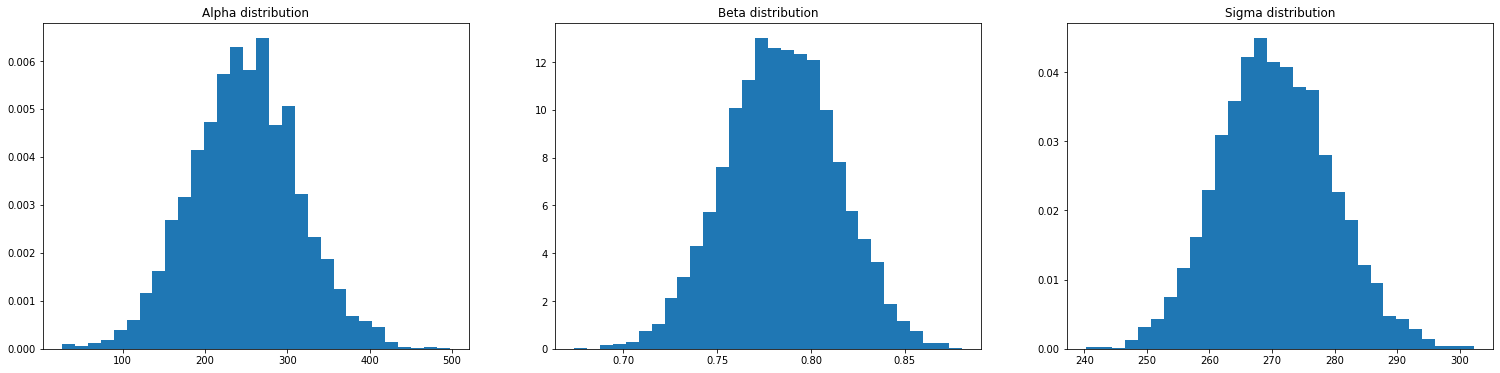

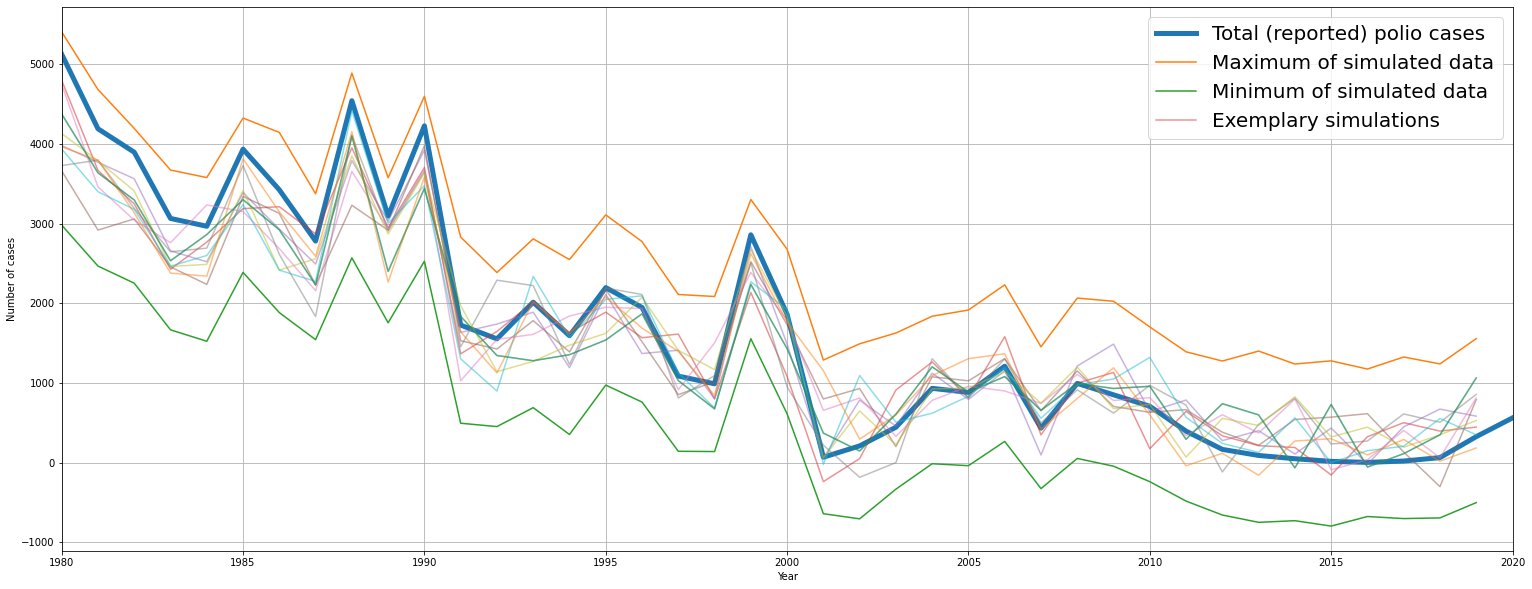

In [9]:
africa_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases']][:-1]
model_data_dict = {'N': len(africa_data['Year']),
                    'y': africa_data['Total (reported) polio cases']}
autoregressive_sim_sampling = model.sample(data = model_data_dict, seed = global_seed, iter_sampling=1000)
y_sim = autoregressive_sim_sampling.stan_variable('y_sim')

sim_max = list()
sim_min = list()
for i in range(1, len(y_sim[0])):
    sim_max.append(np.max(y_sim[:,i]))
    sim_min.append(np.min(y_sim[:,i]))
    
plot_distributions(autoregressive_sim_sampling)

plt.figure(figsize=(26, 10))
plt.grid(True)
plt.locator_params(axis="both", integer=True, tight=True)
plt.plot(africa_data['Year'],africa_data['Total (reported) polio cases'],linewidth=5)
plt.plot(africa_data['Year'][1:]-1, sim_max)
plt.plot(africa_data['Year'][1:]-1, sim_min)
for i in range(10):
    plt.plot(africa_data['Year']-1,y_sim[random.randint(0, len(y_sim[0]))], alpha = 0.5),

plt.legend(['Total (reported) polio cases', 'Maximum of simulated data', 'Minimum of simulated data', 'Exemplary simulations'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(africa_data['Year']),max(africa_data['Year']))
plt.show()


As can be seen from plotting data, priors are correlated to supplied data with small variations. Prepared data will be used to prepare simulations from two different models. <br><br>

<h3>Model 1 - Linear regression</h3>
As mentioned in the introduction, this model is mainly used for comparison purposes, thus verification of priors would be impossible. Fortunately, priors were verified on autoregressive model, and can be reused in this part for better comparison. Simulating data is not really neccessary, hoever it will be done to illustrate point that for our purpose, linear regression model is not really fit.

In [10]:
stan_file = "stan_models\\linear_sim.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
    int <lower = 0> N; 
    vector[N] y; //cases
    vector[N] x; //years
} 
parameters { 
    real alpha; 
    real beta; 
    real <lower = 0> sigma; 
} 
transformed parameters {
    real mu[N];
    for (n in 2:N){
        mu[n] = alpha + beta * y[n-1];
    }
}
model { 
    alpha ~ normal(1600, 1500);
    beta ~ lognormal(0,1);
    sigma ~ exponential(1);
    y ~ normal(alpha + beta * x, sigma);
} 
generated quantities{ 
    real y_sim[N];
    for (n in 1:N){
        y_sim[n] = normal_rng(alpha + beta * x[n], sigma);
    }
    // One less point for accomodating autoregressive model
    real log_lik[N-1];
    for(j in 2:N){
        log_lik[j-1] = normal_lpdf(y[j]|mu[j],sigma);
    }
} 



INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


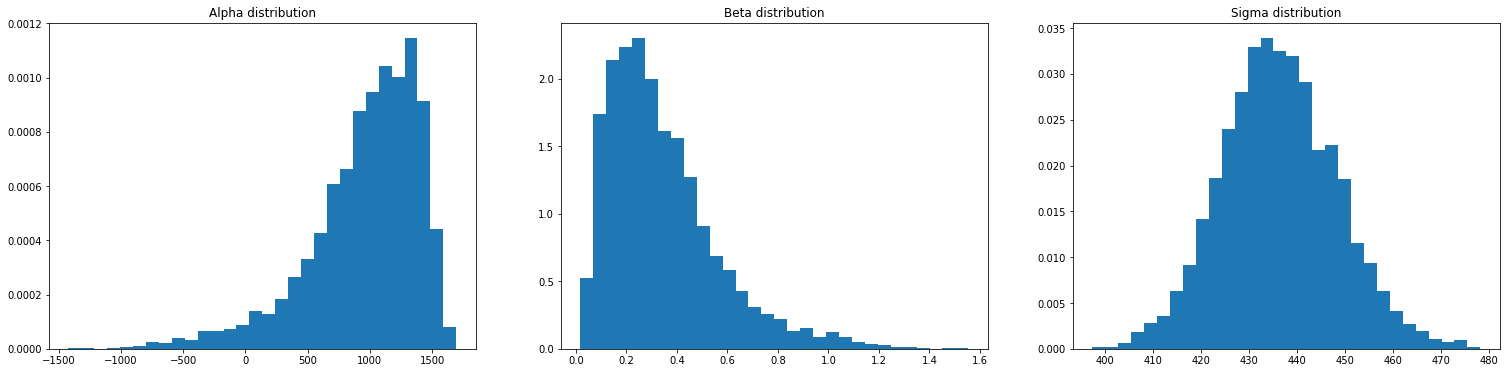

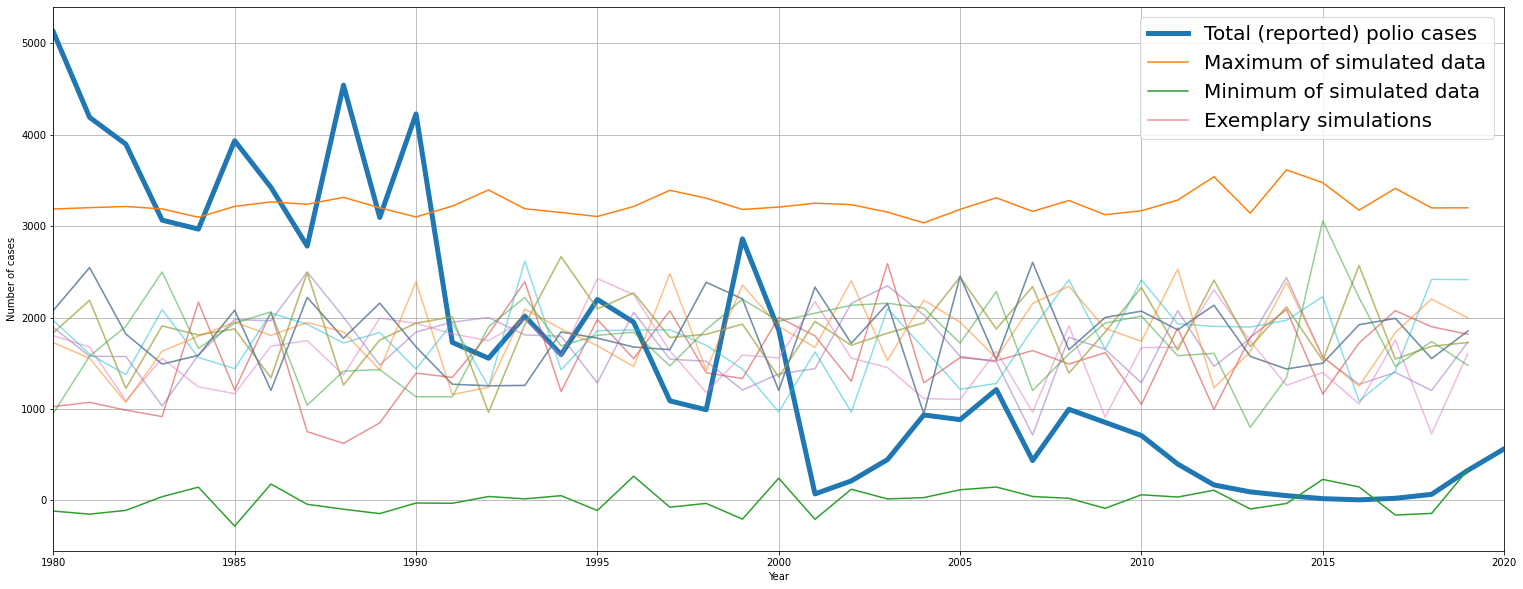

In [11]:
model_data_dict = {'N': len(africa_data['Year']),
                    'x': africa_data['Year'],
                    'y': africa_data['Total (reported) polio cases']
                  }
linear_sim_sampling = model.sample(data = model_data_dict, seed = global_seed, iter_sampling=1000)
y_sim = linear_sim_sampling.stan_variable('y_sim')

sim_max = list()
sim_min = list()
for i in range(1, len(y_sim[0])):
    sim_max.append(np.max(y_sim[:,i]))
    sim_min.append(np.min(y_sim[:,i]))
    
plot_distributions(linear_sim_sampling)

plt.figure(figsize=(26, 10))
plt.grid(True)
plt.locator_params(axis="both", integer=True, tight=True)
plt.plot(africa_data['Year'],africa_data['Total (reported) polio cases'],linewidth=5)
plt.plot(africa_data['Year'][1:]-1, sim_max)
plt.plot(africa_data['Year'][1:]-1, sim_min)
for i in range(10):
    plt.plot(africa_data['Year']-1,y_sim[random.randint(0, len(y_sim[0]))], alpha = 0.5),

plt.legend(['Total (reported) polio cases', 'Maximum of simulated data', 'Minimum of simulated data', 'Exemplary simulations'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(africa_data['Year']),max(africa_data['Year']))
plt.show()

As predicted, linear regression is not a best fit for given task, but can give some knowledge from analysys. Priors could not be verified from that model.

<h4>Moddeling</h4>

In [12]:
stan_file = "stan_models\\linear_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
    int <lower = 0> N; 
    vector [N] y; //cases
    vector [N] x; //years
    int x_pred; //predicted year
} 
parameters { 
    real alpha; 
    real beta; 
    real <lower = 0> sigma; 
} 
model { 
    alpha ~ normal(1600, 1500);
    beta ~ lognormal(0,1);
    sigma ~ exponential(1);
    y ~ normal(alpha + beta * x, sigma);
} 
generated quantities{ 
    real y_pred = normal_rng(alpha + beta * x_pred , sigma);
} 


INFO:cmdstanpy:compiling stan file C:\Users\solar\Desktop\DataAnalysisProject\stan_models\linear_model.stan to exe file C:\Users\solar\Desktop\DataAnalysisProject\stan_models\linear_model.exe
INFO:cmdstanpy:compiled model executable: C:\Users\solar\Desktop\DataAnalysisProject\stan_models\linear_model.exe


Predictions for thew whole avaiable data

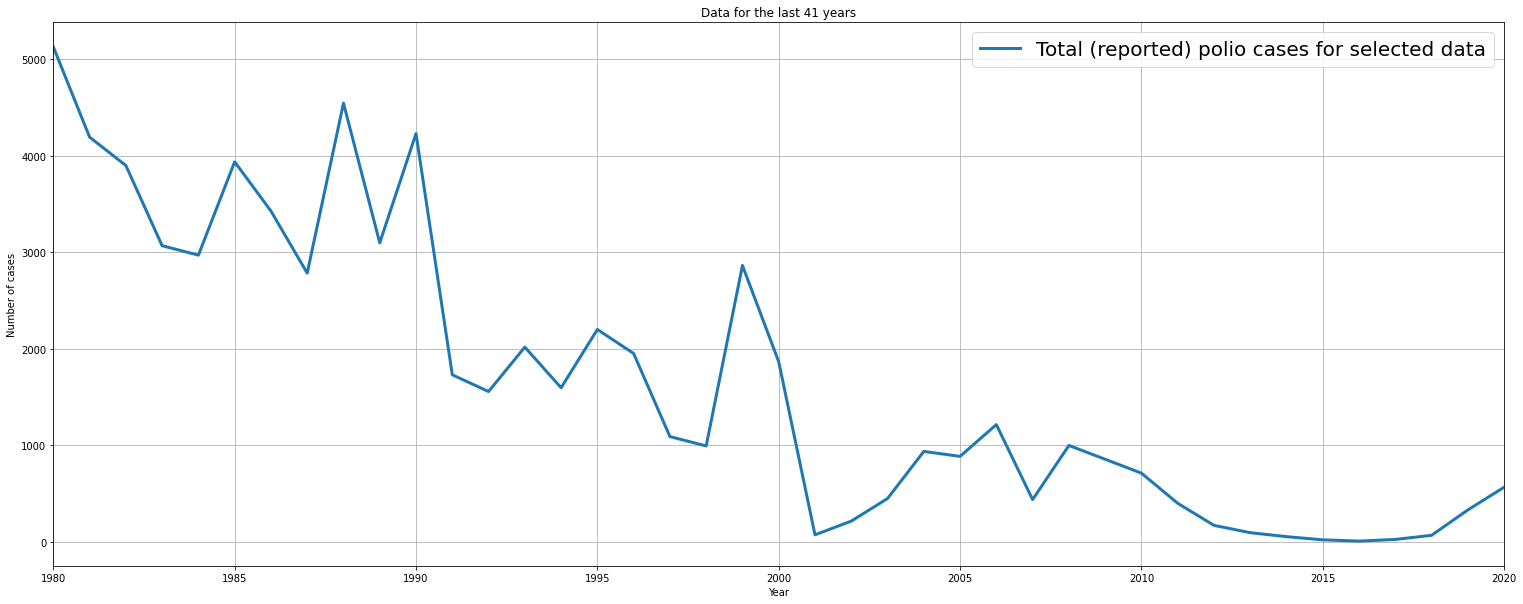

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [13]:
selected_data_whole = select_data('Africa')
plot_selected_data(selected_data_whole)

model_data_dict = {'N': len(selected_data_whole['Year']),
                    'x': selected_data_whole['Year'],
                    'y': selected_data_whole['Cases'],
                    'x_pred': selected_data_whole['Year'][-1] + 1
                  }

fit_linear_whole = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)

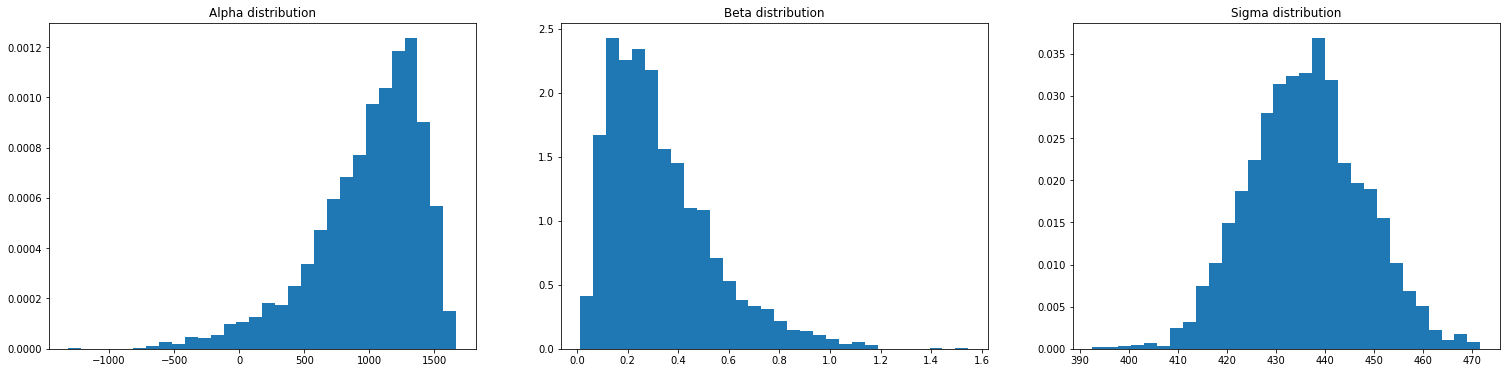

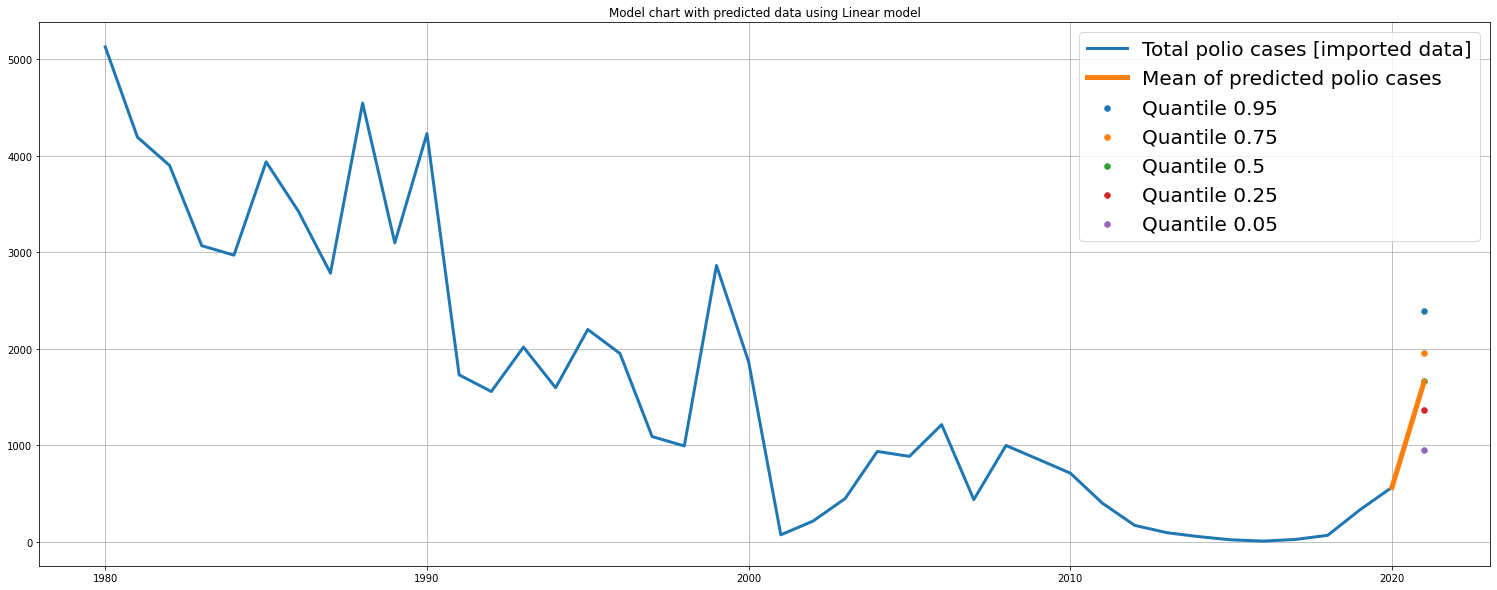

[Linear] Predicted mean value of Polio cases for year 2021: 1659


In [14]:
plot_distributions(fitted_model=fit_linear_whole)
plot_predictions_chart(selected_data_whole, fit_linear_whole.stan_variable('y_pred'), 2021, type='Linear')

Predictions for last decade

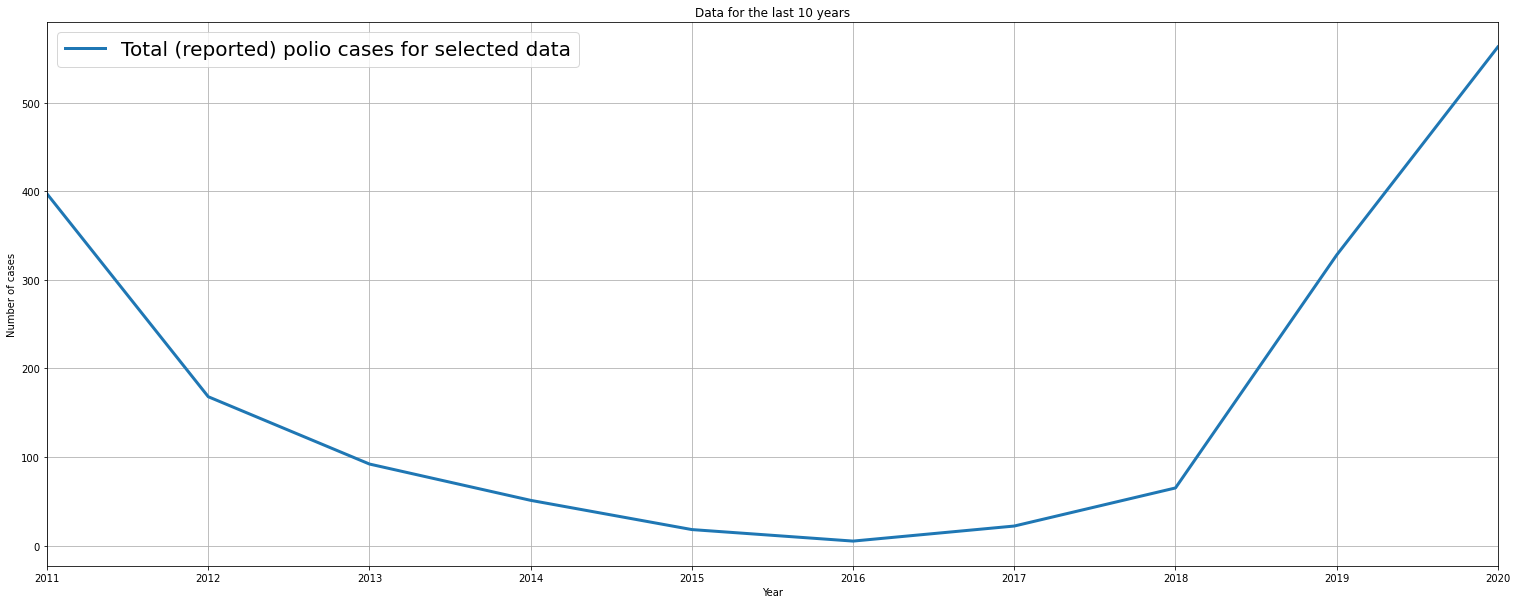

In [15]:
selected_data_decade = select_data('Africa', 10)
plot_selected_data(selected_data_decade)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


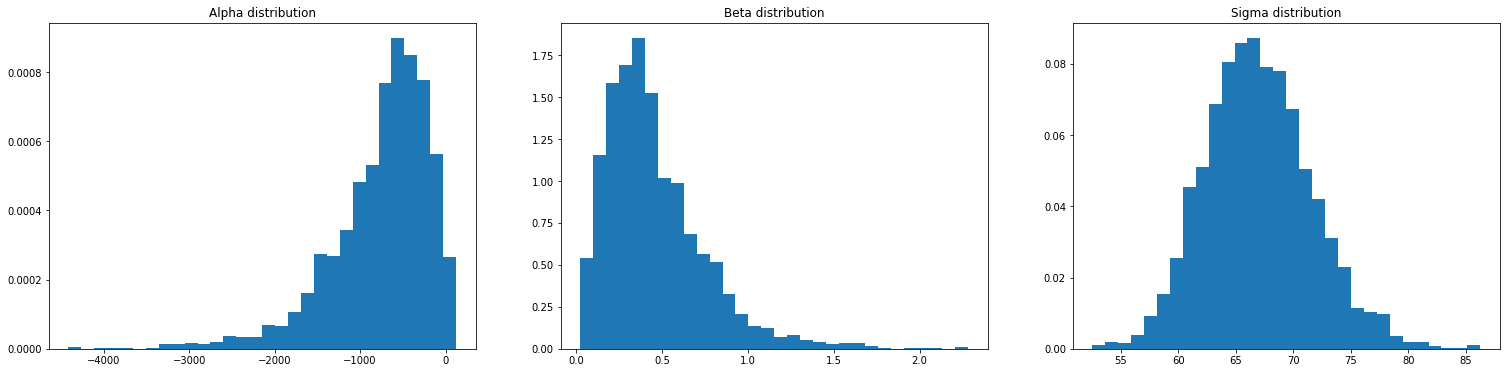

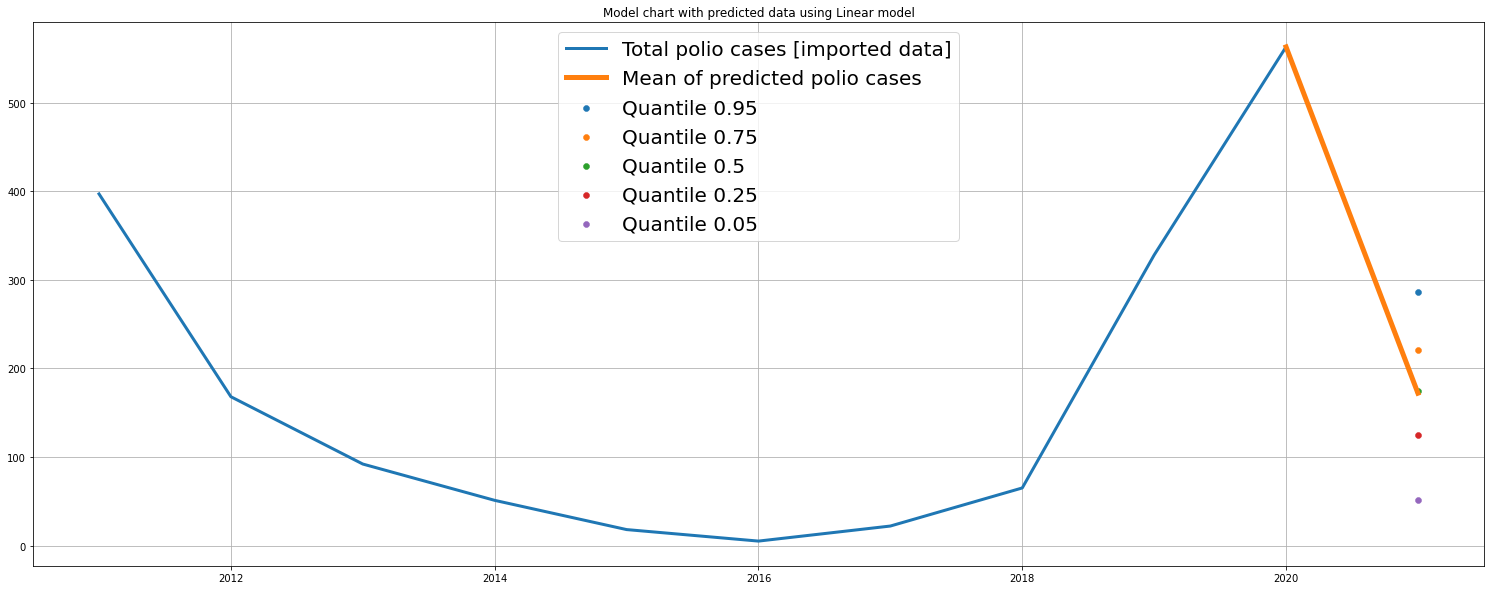

[Linear] Predicted mean value of Polio cases for year 2021: 172


In [16]:
model_data_dict = {'N': len(selected_data_decade['Year']),
                    'x': selected_data_decade['Year'],
                    'y': selected_data_decade['Cases'],
                    'x_pred': selected_data_decade['Year'][-1] + 1,
                  }


fit_linear_decade = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_linear_decade)
plot_predictions_chart(selected_data_decade, fit_linear_decade.stan_variable('y_pred'), 2021, type='Linear')

Predictions for last 5 years (growths)

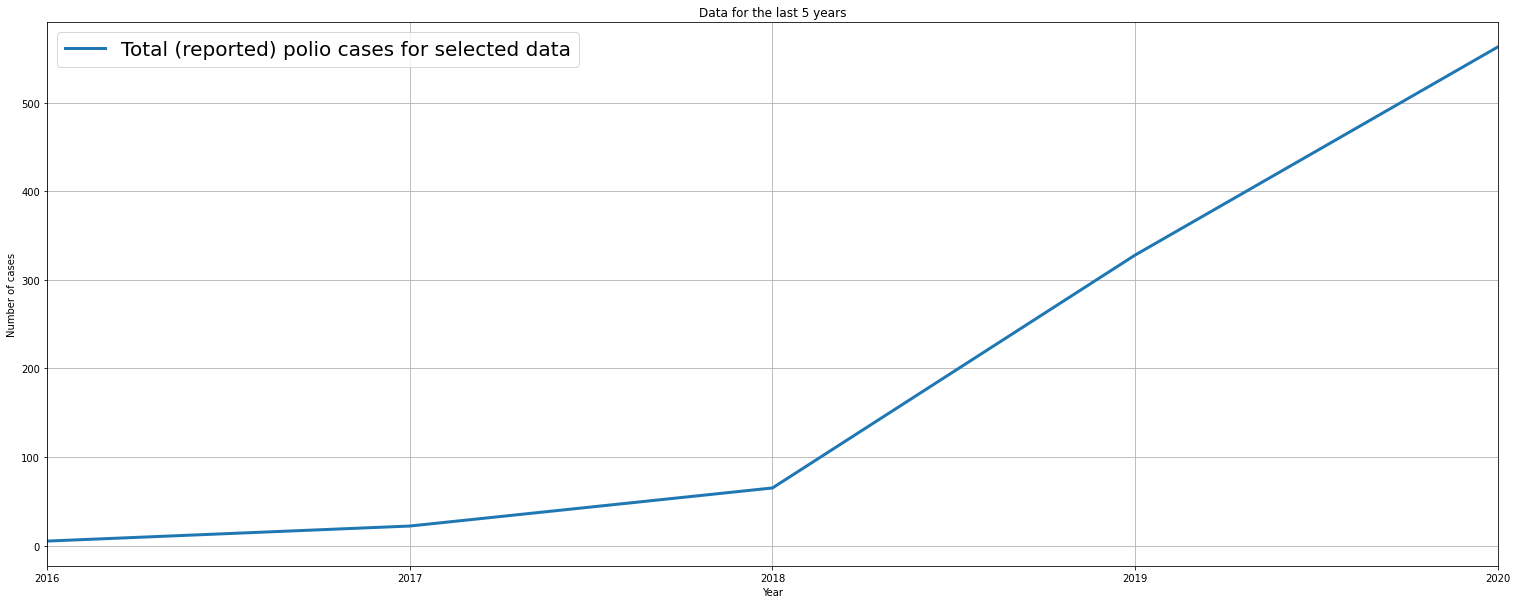

In [17]:
selected_data_growths = select_data('Africa', 5)
plot_selected_data(selected_data_growths)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


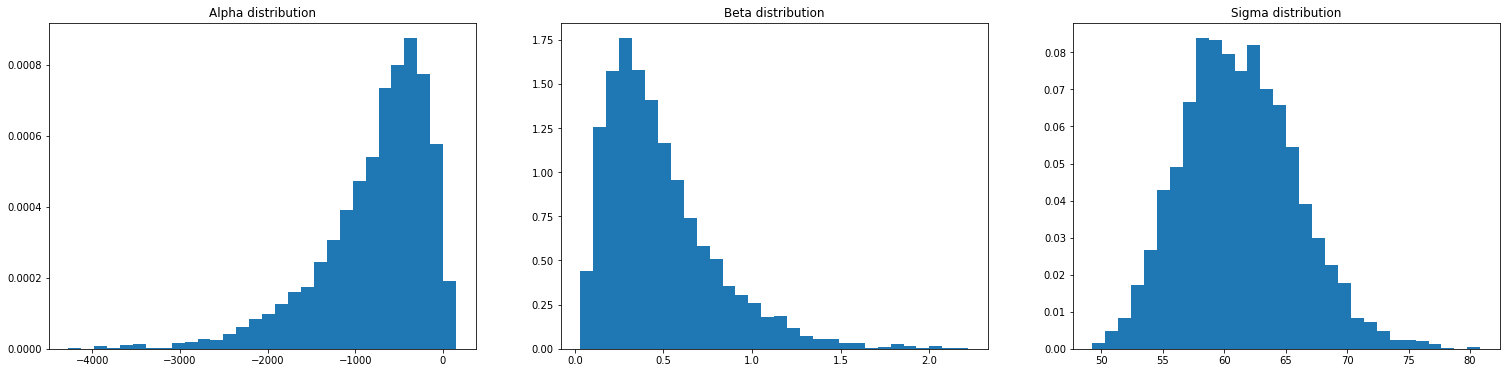

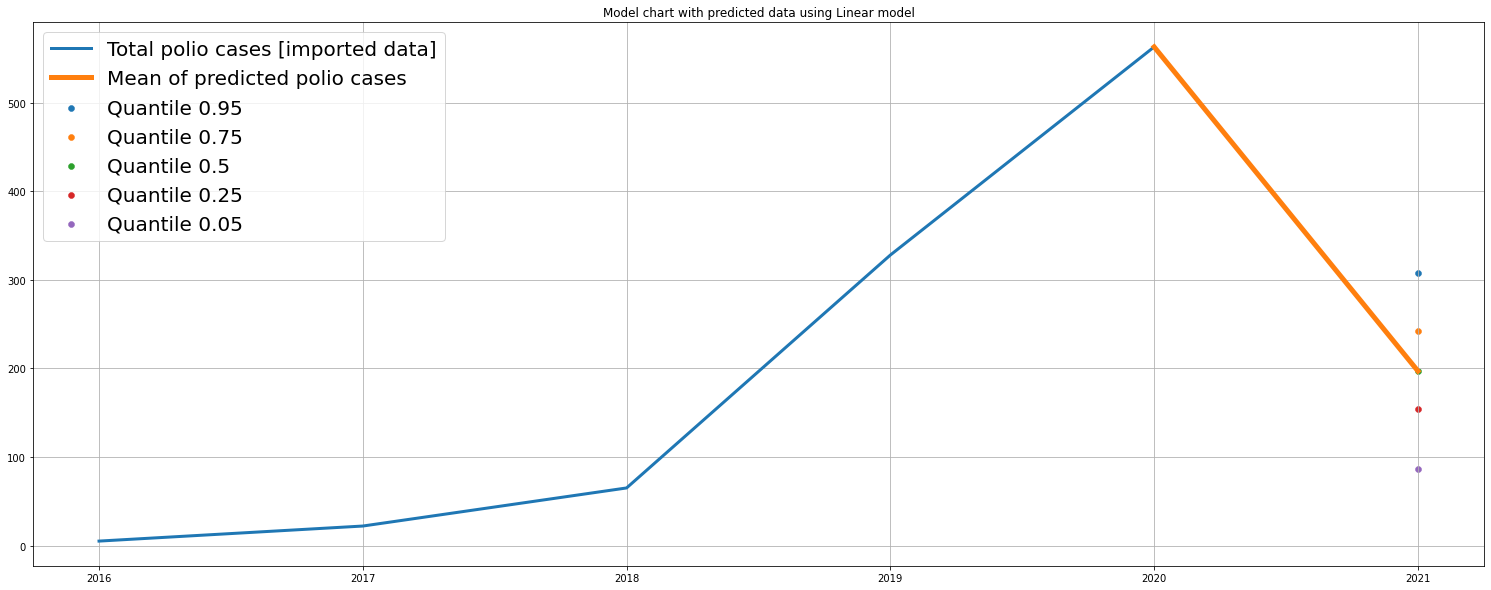

[Linear] Predicted mean value of Polio cases for year 2021: 197


In [18]:
model_data_dict = {'N': len(selected_data_growths['Year']),
                    'x': selected_data_growths['Year'],
                    'y': selected_data_growths['Cases'],
                    'x_pred': selected_data_growths['Year'][-1] + 1,
                  }

fit_linear_growths = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_linear_growths)
plot_predictions_chart(selected_data_growths, fit_linear_growths.stan_variable('y_pred'), 2021, type='Linear')

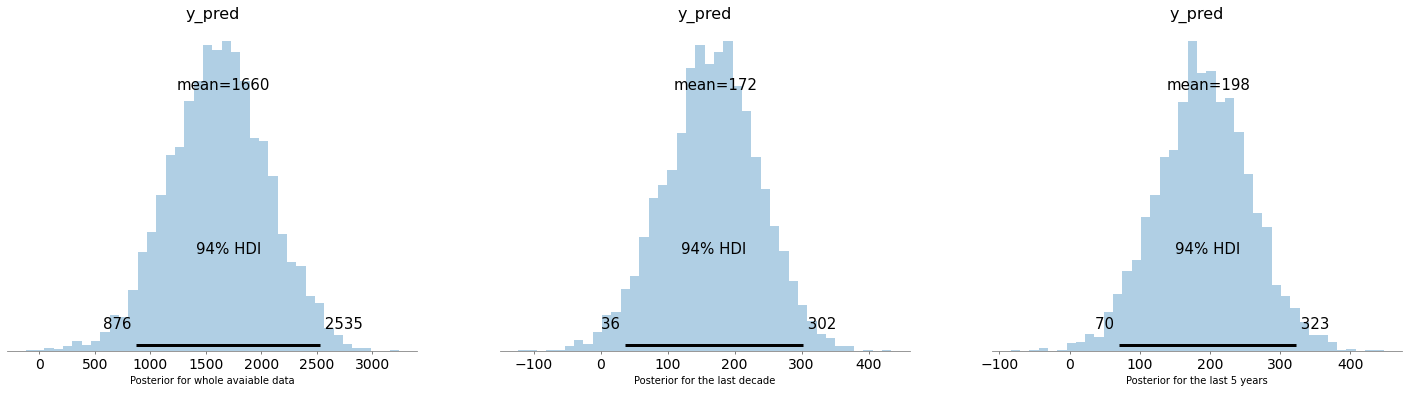

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
az.plot_posterior(fit_linear_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Posterior for whole avaiable data');
az.plot_posterior(fit_linear_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Posterior for the last decade');
az.plot_posterior(fit_linear_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Posterior for the last 5 years');
plt.show()

As can be seen, values are pretty spread apart, which means that models are not giving much certainty of their predictions. Apart from that, models are behaving differently for given scenarios, and thus also ensures, that linear regression is not the best choice for given task.

<h4>Conclusions</h4>
Linear regression is not suited for given task. Posteriors given above are wide and are changing by changing the scope. This model is not really able to predict with some degree of certainty what number of cases will appear next year. From fitting to linear regression, models tend to forcefully predict lower values than it would be logical. However, there were no problems with sampling, so the linear regression model is flexible enough to accept this format. 

<h2>Model 2 - Autoregressive</h2>
As steted in prioject description diesese is strictly connected with active infected people first model will be created on basis of autoregression.
Due to better fit for given task, this model should give better results in predicting evolution of diesese.


In [20]:
stan_file = "stan_models\\autoregressive_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
  int <lower = 0> N; 
  vector [N] y; 
} 
 
parameters { 
  real alpha; 
  real beta;
  real <lower = 0> sigma; 
} 
model { 
  alpha ~ normal(1600, 1500);
  beta ~ lognormal(0,1);
  sigma ~ exponential(1);
  for (n in 2:N){
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
  }
} 
generated quantities{ 
  real y_pred = normal_rng(alpha + beta * y[N], sigma); 
} 



INFO:cmdstanpy:compiling stan file C:\Users\solar\Desktop\DataAnalysisProject\stan_models\autoregressive_model.stan to exe file C:\Users\solar\Desktop\DataAnalysisProject\stan_models\autoregressive_model.exe
INFO:cmdstanpy:compiled model executable: C:\Users\solar\Desktop\DataAnalysisProject\stan_models\autoregressive_model.exe


Fitting model to whole avaiable data

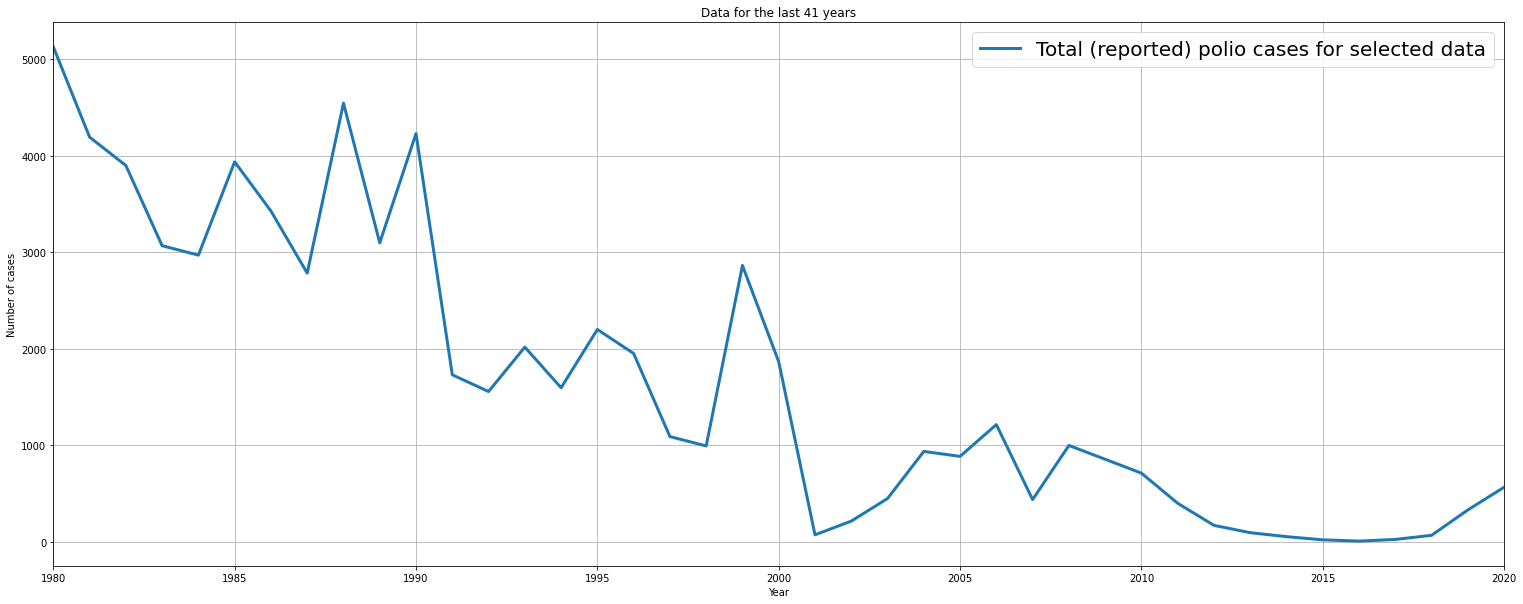

In [21]:
plot_selected_data(selected_data_whole)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


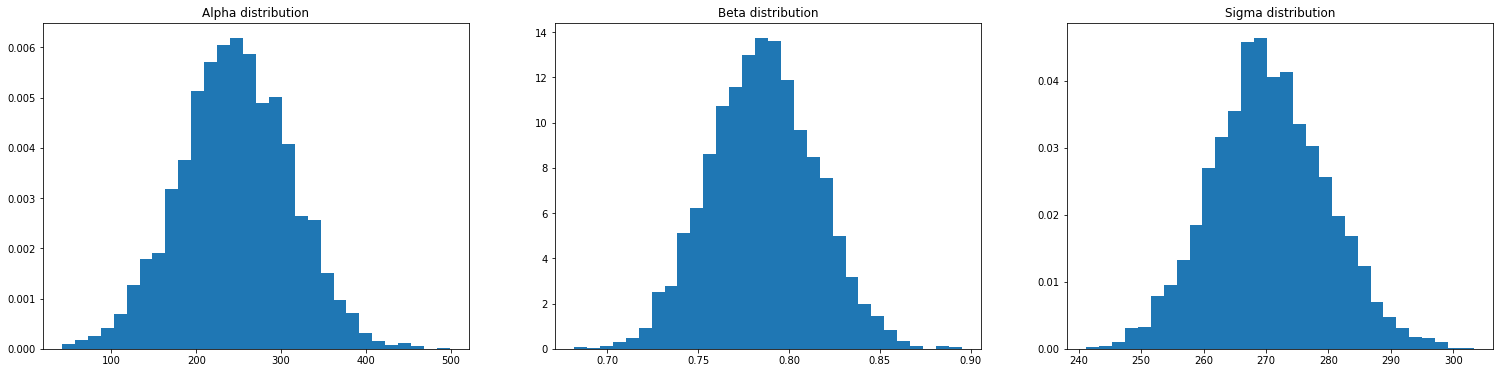

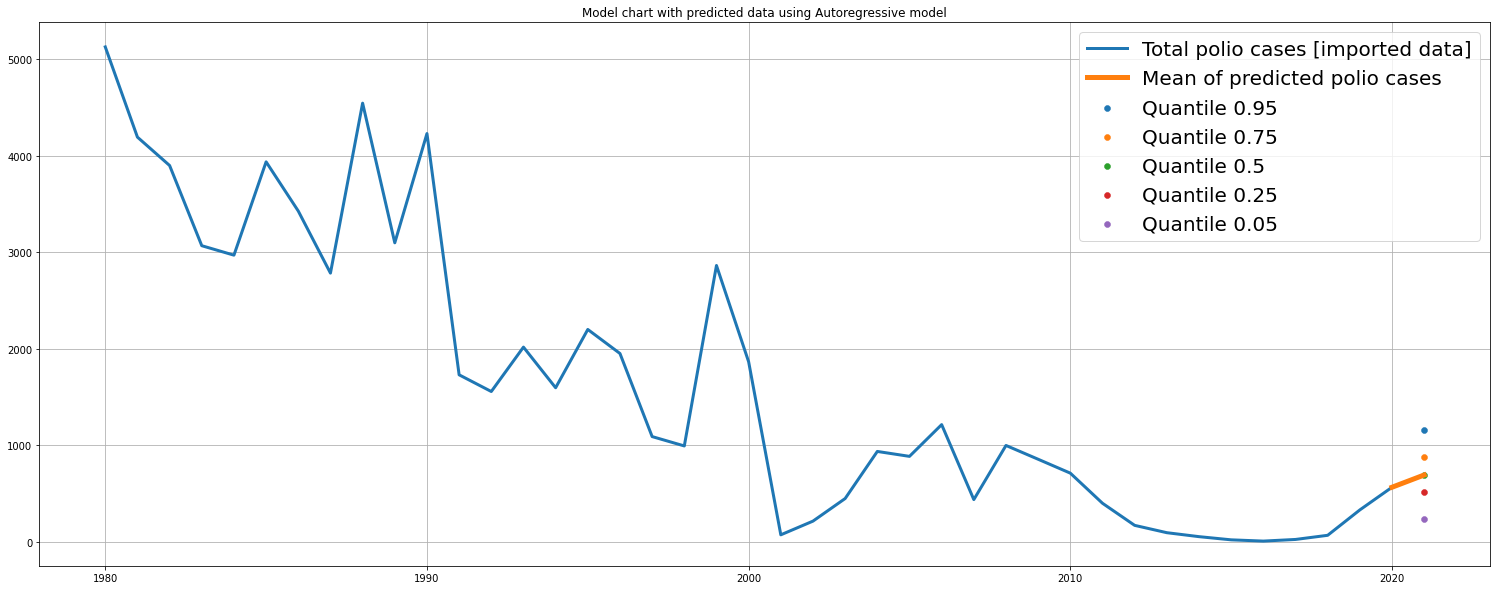

[Autoregressive] Predicted mean value of Polio cases for year 2021: 690


In [22]:
model_data_dict = {'N': len(selected_data_whole['Year']),
                    'x': selected_data_whole['Year'],
                    'y': selected_data_whole['Cases'],
                    'x_pred': selected_data_whole['Year'][-1] + 1,
                  }

fit_autoregressive_whole = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_whole)
plot_predictions_chart(selected_data_whole, fit_autoregressive_whole.stan_variable('y_pred'), 2021, type='Autoregressive')

Predictions for last decade

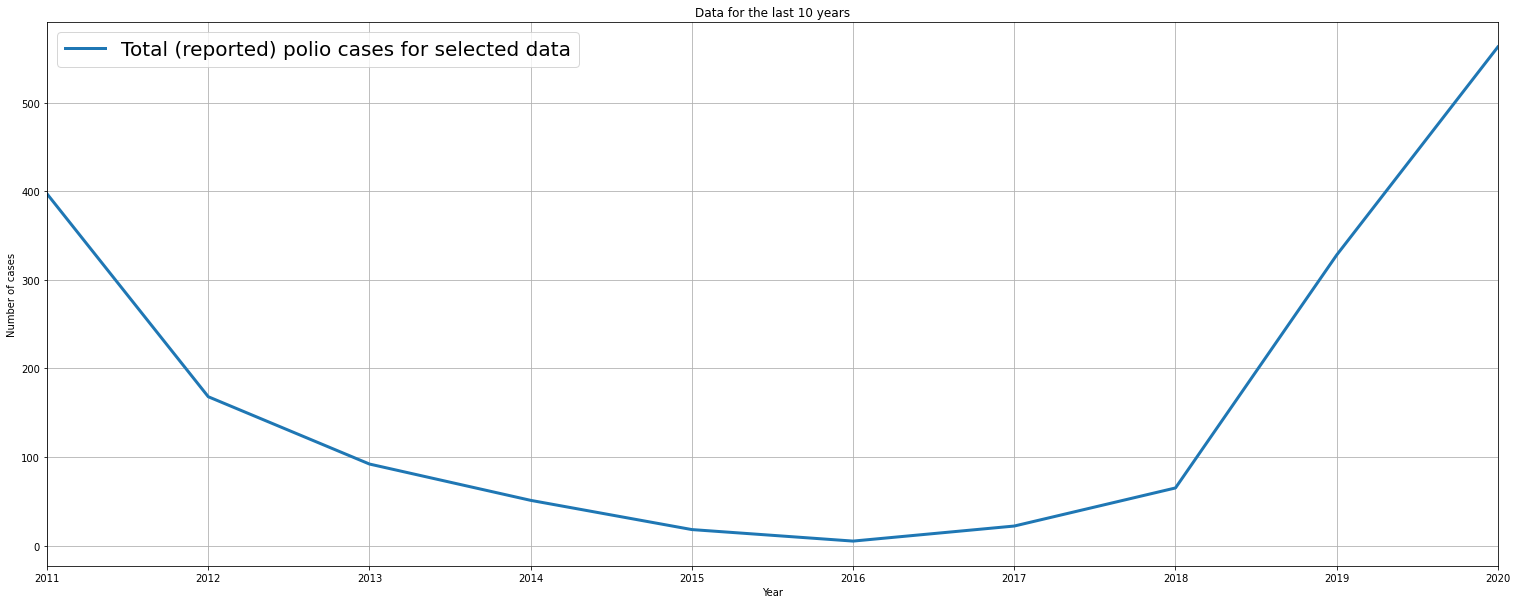

In [23]:
plot_selected_data(selected_data_decade)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


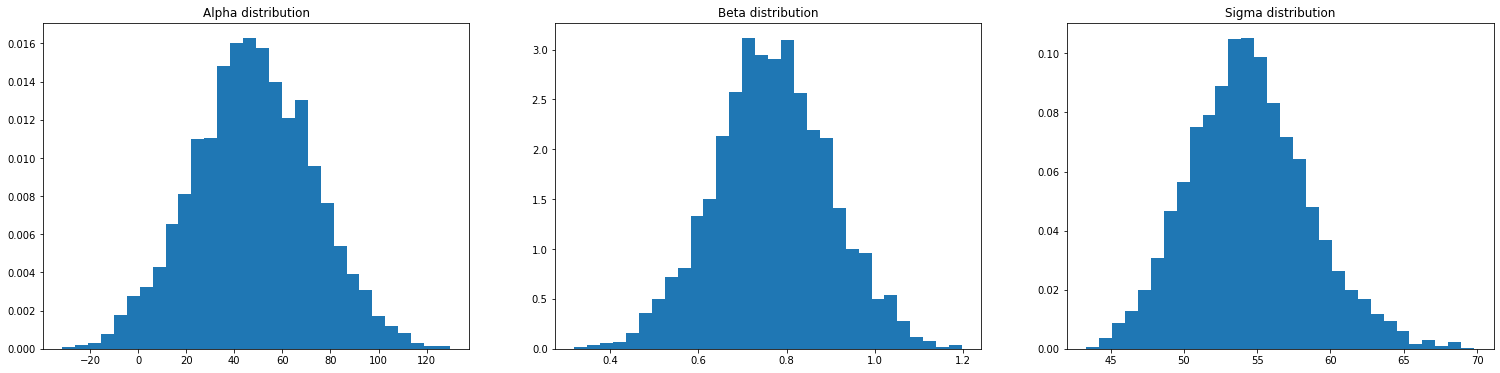

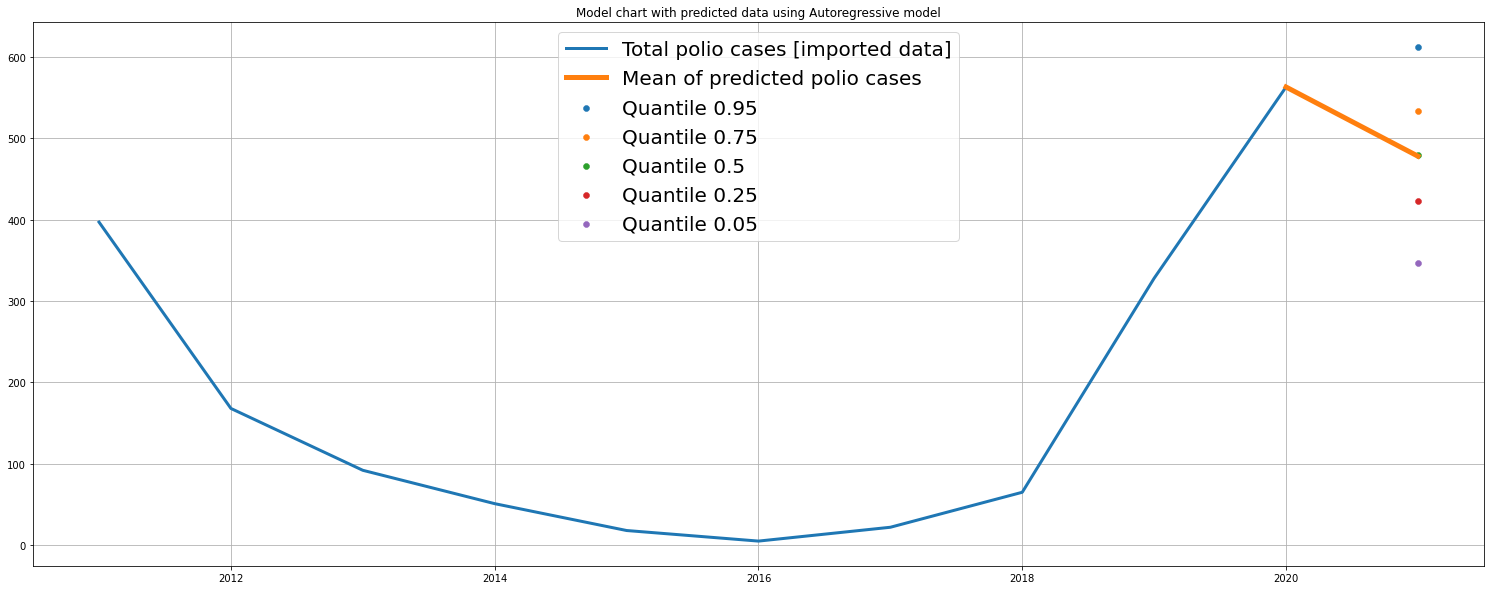

[Autoregressive] Predicted mean value of Polio cases for year 2021: 478


In [24]:
model_data_dict = {'N': len(selected_data_decade['Year']),
                    'x': selected_data_decade['Year'],
                    'y': selected_data_decade['Cases'],
                    'x_pred': selected_data_decade['Year'][-1] + 1,
                  }

fit_autoregressive_decade = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_decade)
plot_predictions_chart(selected_data_decade, fit_autoregressive_decade.stan_variable('y_pred'), 2021, type='Autoregressive')

Predictions for last 5 years (growths)

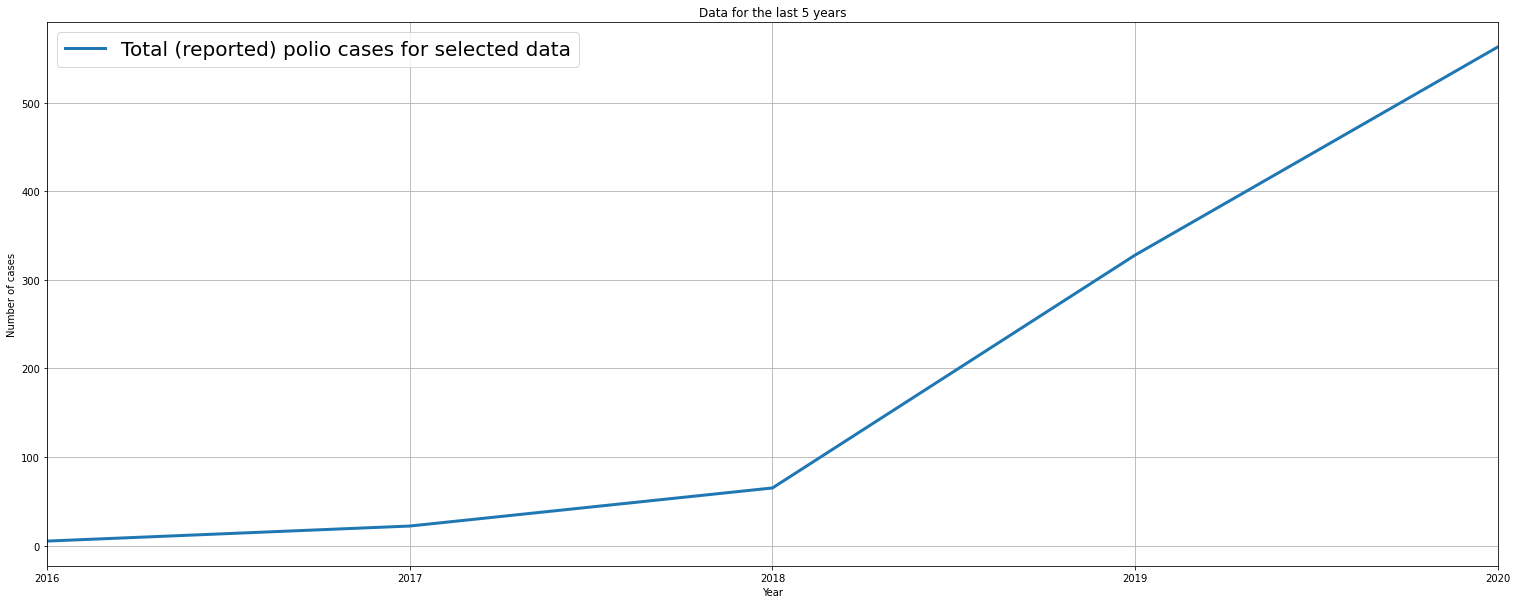

In [25]:
plot_selected_data(selected_data_growths)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


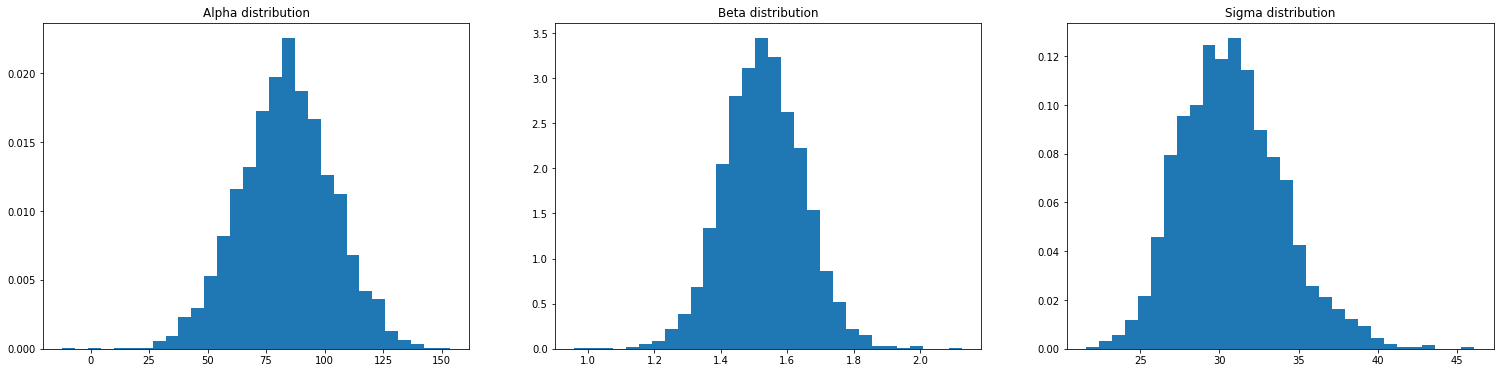

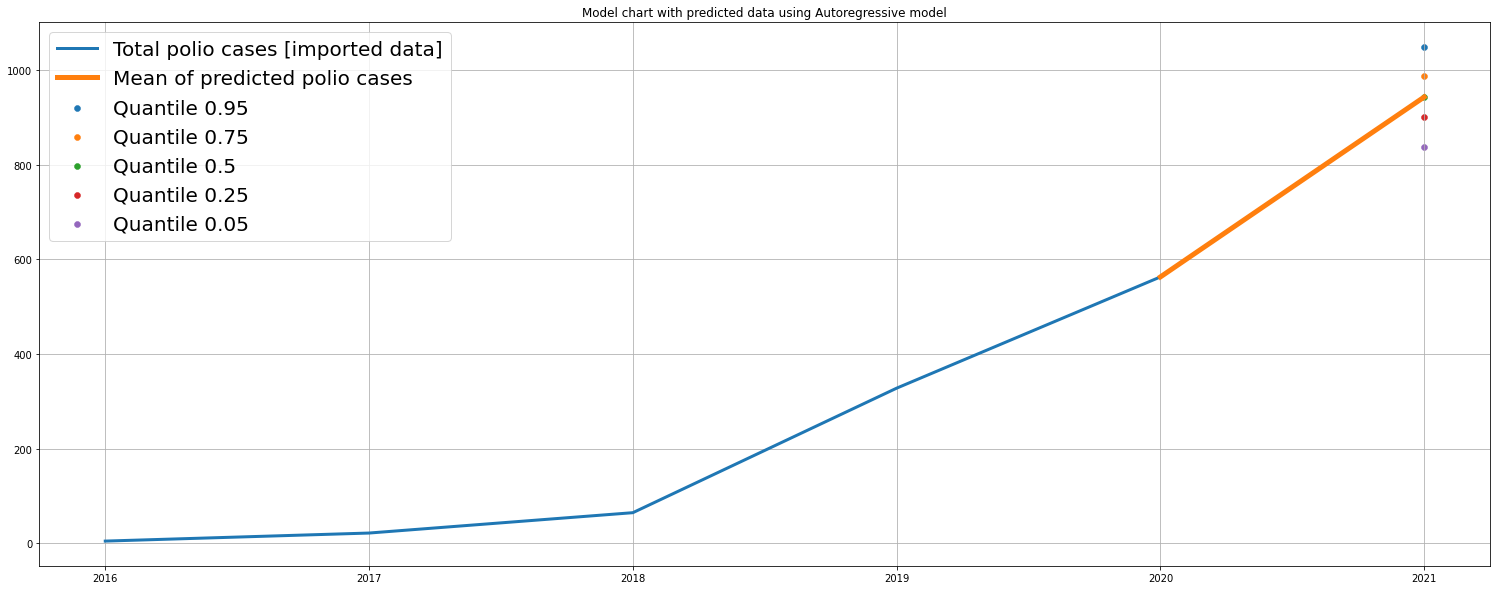

[Autoregressive] Predicted mean value of Polio cases for year 2021: 943


In [26]:
model_data_dict = {'N': len(selected_data_growths['Year']),
                    'x': selected_data_growths['Year'],
                    'y': selected_data_growths['Cases'],
                    'x_pred': selected_data_growths['Year'][-1] + 1}

fit_autoregressive_growths = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_growths)
plot_predictions_chart(selected_data_growths, fit_autoregressive_growths.stan_variable('y_pred'), 2021, type='Autoregressive')

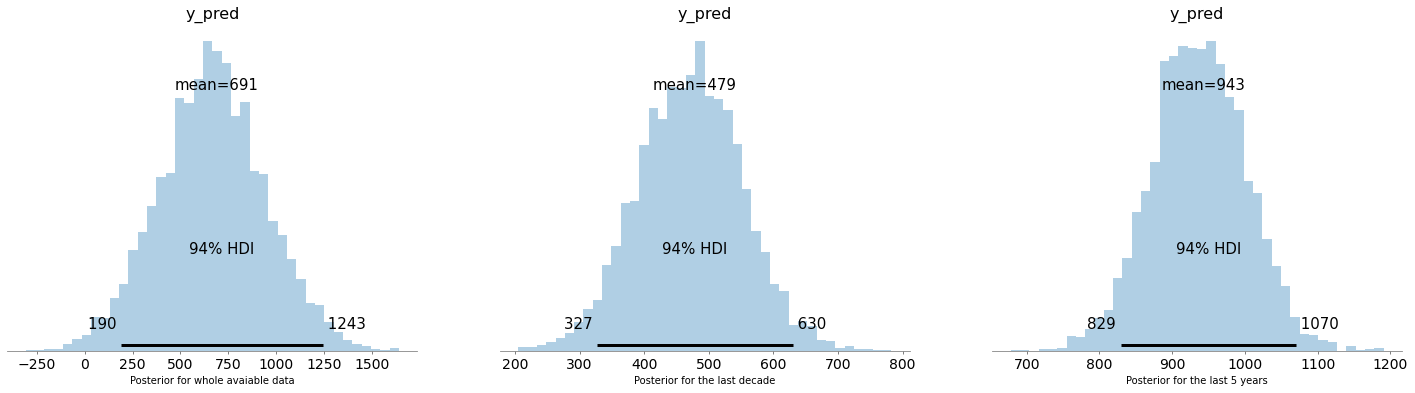

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
az.plot_posterior(fit_autoregressive_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Posterior for whole avaiable data');
az.plot_posterior(fit_autoregressive_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Posterior for the last decade');
az.plot_posterior(fit_autoregressive_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Posterior for the last 5 years');
plt.show()

As can be seen, predicted values are also much spread apart, as in linear regression model, which means that models are not giving much certainty, hoever their values are more visually and logically correct. 

<h4>Conclusions</h4>
Autoregressive model is far better suited for given task than linear regression. Data is predicted far less "crazy" than in linear model and model behaves more predictable for that task. Limitation of this model is that it is using previous data (one point in first-order case), so must be shifted for calculations from point of start, e.g. simulating can start from second point as first is used in calculations. Apart from that, there were no issues with sampling, and model do not have to be provided with "x" set of points, as it have to be done in linear regression model.

<h2>Models comparisons</h2>
To strengthen points given in previous analysis, created plots will be presented side by side to spot differences in models and show that autoregressive model is behaving in way we would be expecting in contrast to less predictable linear regression model.

<h3>Predictions comparison</h3>
<h4>Whole avaiable data</h4>

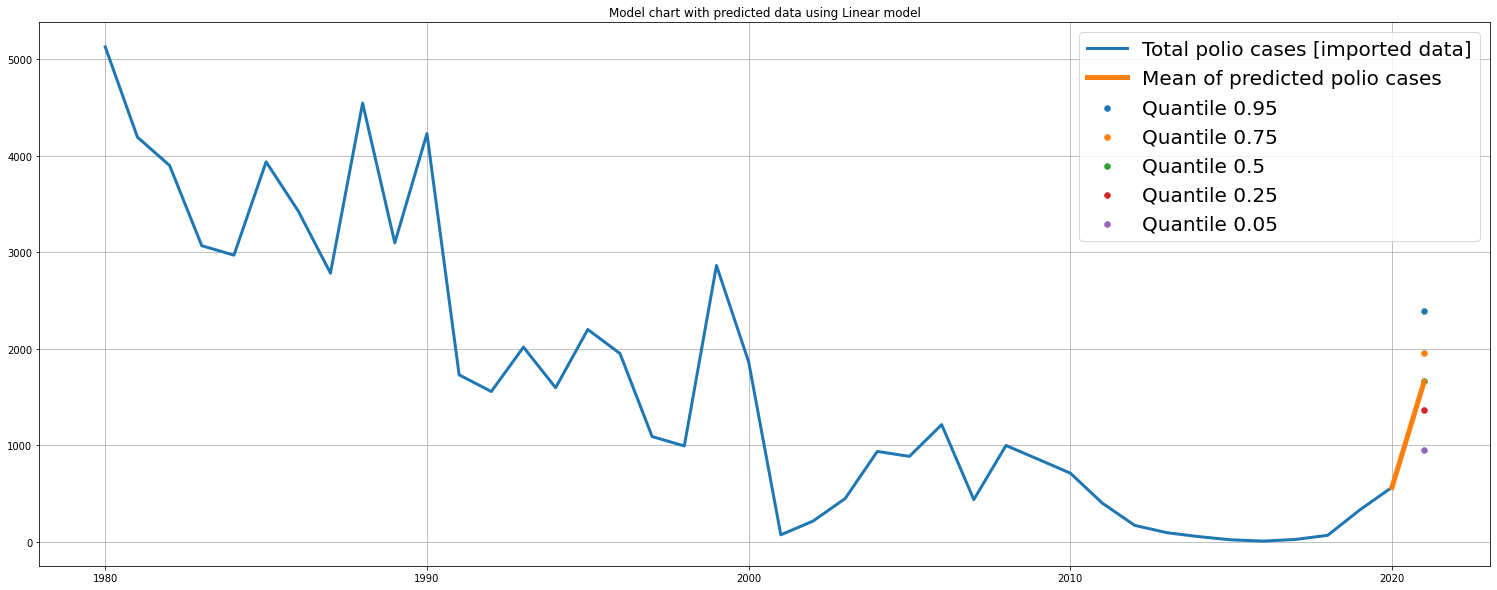

[Linear] Predicted mean value of Polio cases for year 2021: 1659


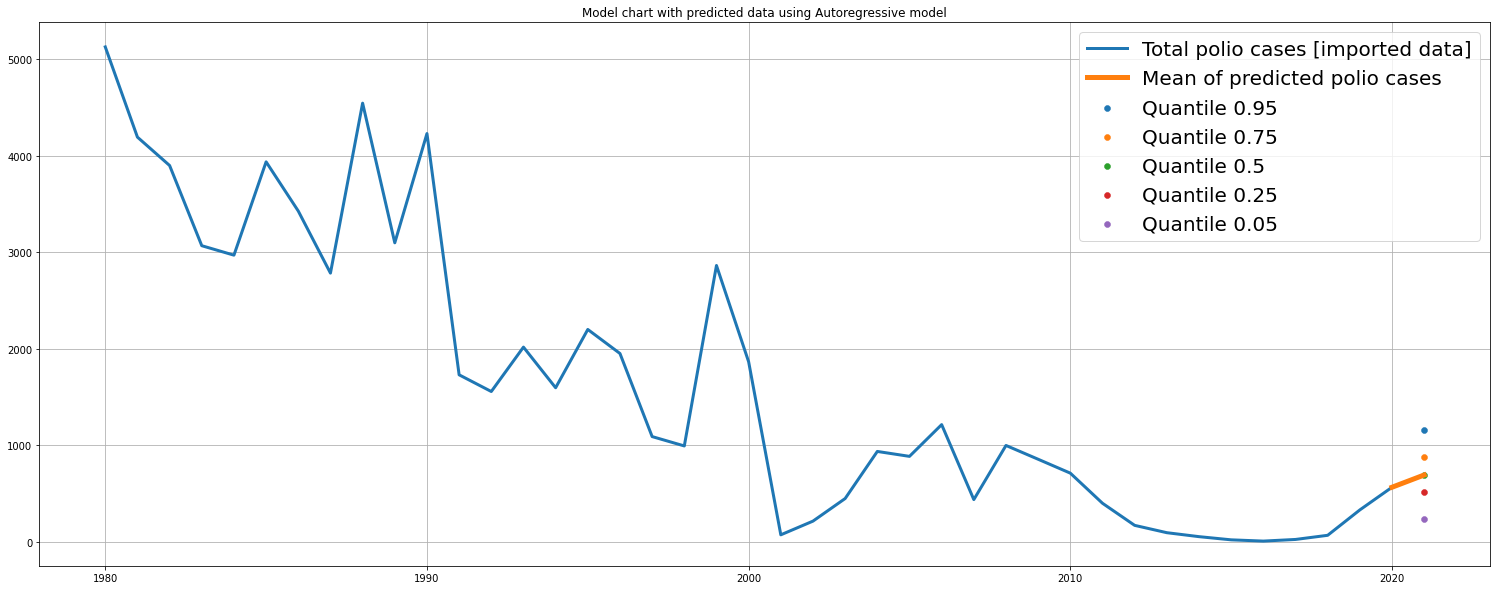

[Autoregressive] Predicted mean value of Polio cases for year 2021: 690


In [28]:
plot_predictions_chart(selected_data_whole, fit_linear_whole.stan_variable('y_pred'), 2021, type='Linear')
plot_predictions_chart(selected_data_whole, fit_autoregressive_whole.stan_variable('y_pred'), 2021, type='Autoregressive')

<h4>Last decade</h4>

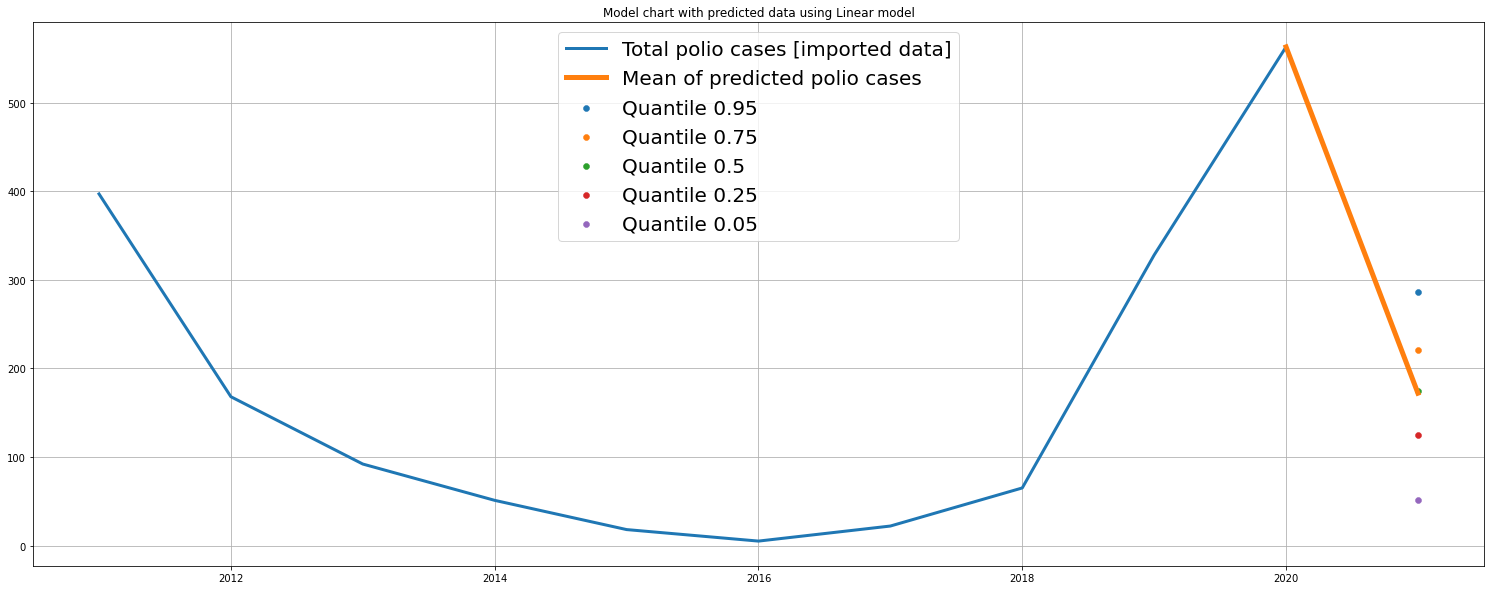

[Linear] Predicted mean value of Polio cases for year 2021: 172


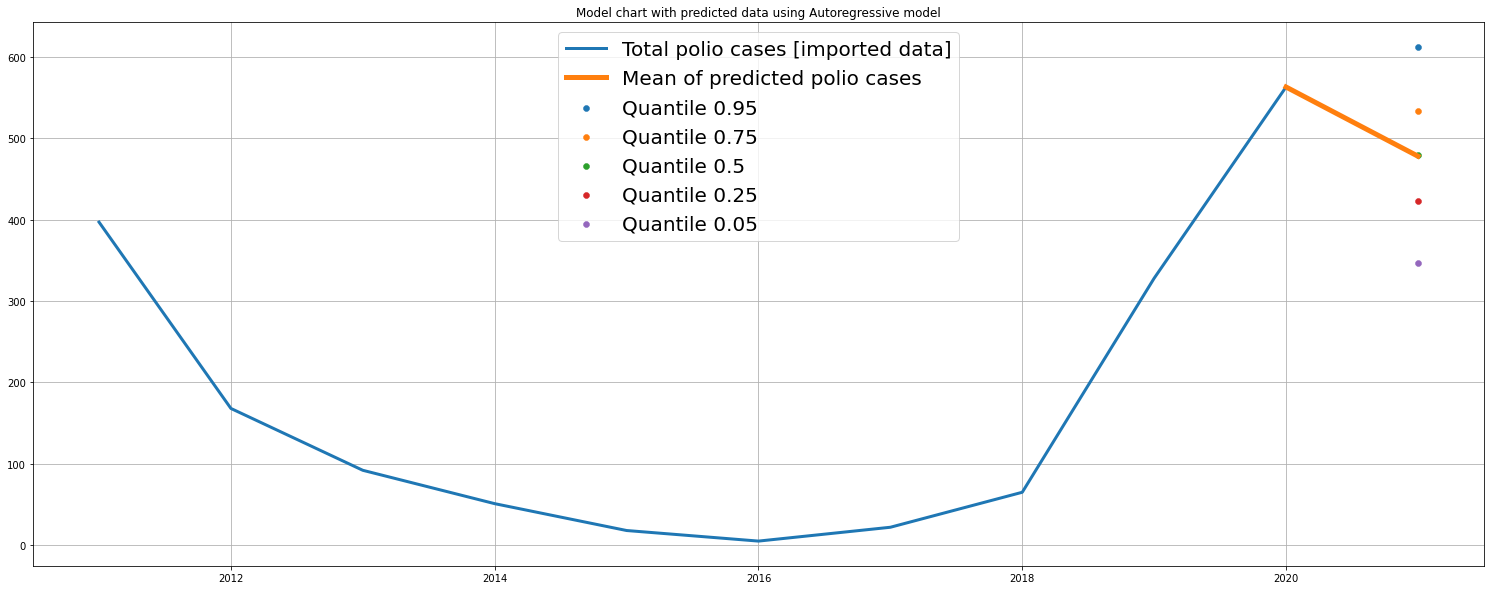

[Autoregressive] Predicted mean value of Polio cases for year 2021: 478


In [29]:
plot_predictions_chart(selected_data_decade, fit_linear_decade.stan_variable('y_pred'), 2021, type='Linear')
plot_predictions_chart(selected_data_decade, fit_autoregressive_decade.stan_variable('y_pred'), 2021, type='Autoregressive')

<h4>Last 5 years (growths)</h4>

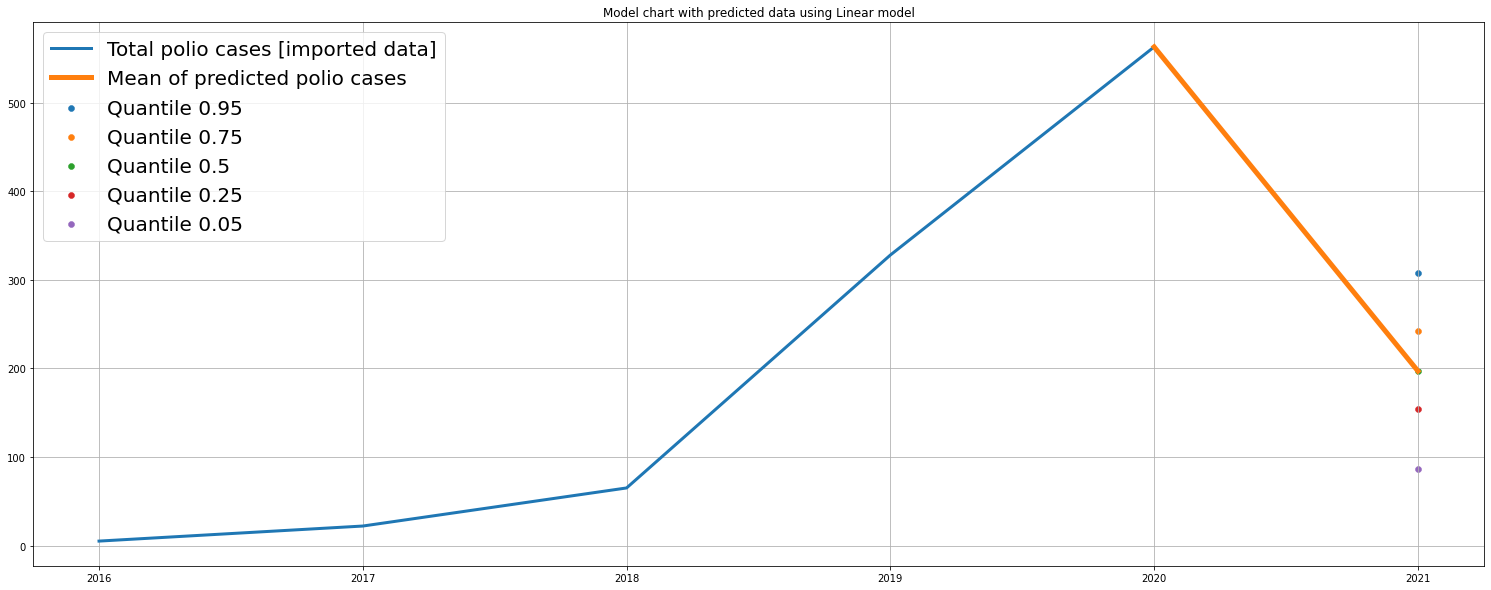

[Linear] Predicted mean value of Polio cases for year 2021: 197


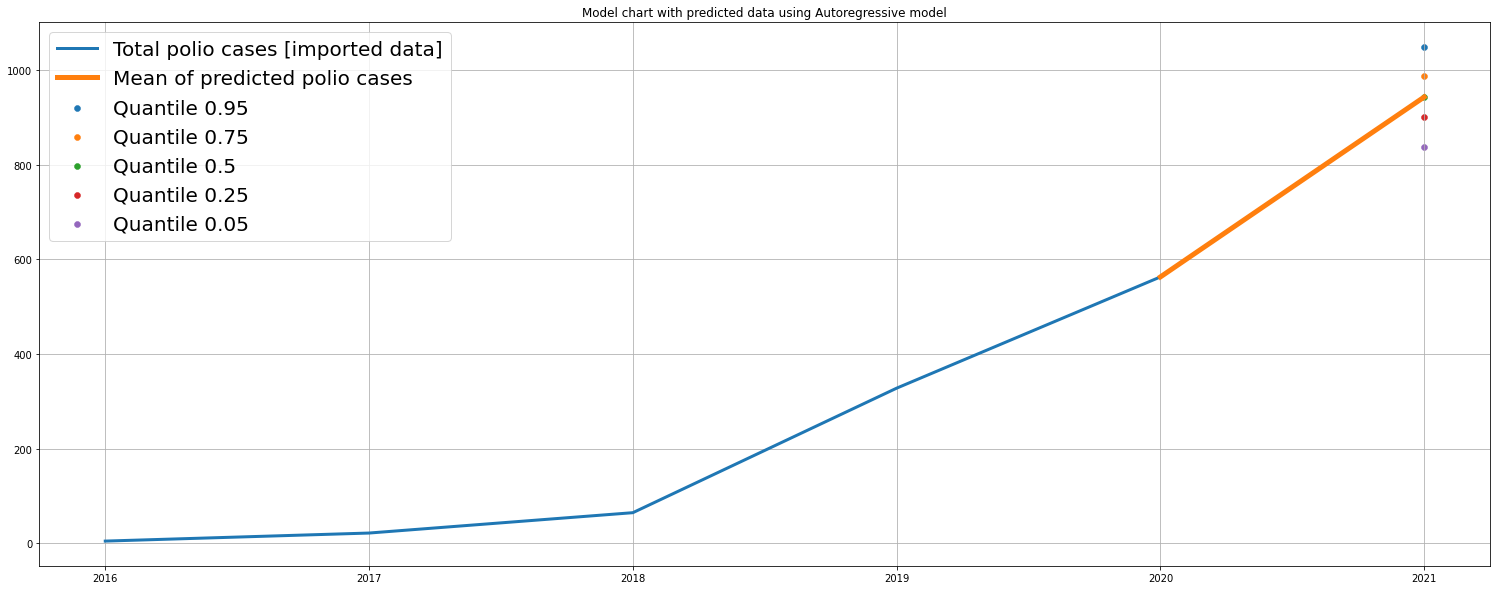

[Autoregressive] Predicted mean value of Polio cases for year 2021: 943


In [30]:
plot_predictions_chart(selected_data_growths, fit_linear_growths.stan_variable('y_pred'), 2021, type='Linear')
plot_predictions_chart(selected_data_growths, fit_autoregressive_growths.stan_variable('y_pred'), 2021, type='Autoregressive')

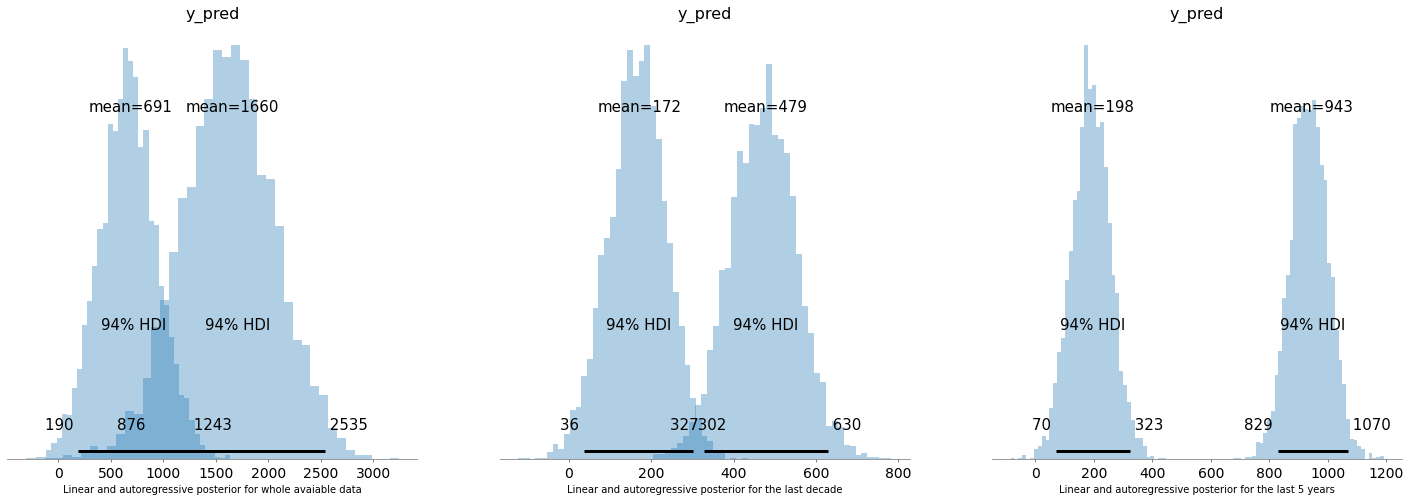

MEAN VALUES:
Linear whole data:  1659
Autoregressive whole data:  690 

Linear last decade:  172
Autoregressive last decade:  478 

Linear last 5 years:  197
Autoregressive last 5 years:  943 



In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,8))
az.plot_posterior(fit_linear_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
az.plot_posterior(fit_autoregressive_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Linear and autoregressive posterior for whole avaiable data');
az.plot_posterior(fit_linear_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
az.plot_posterior(fit_autoregressive_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Linear and autoregressive posterior for the last decade');
az.plot_posterior(fit_linear_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
az.plot_posterior(fit_autoregressive_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Linear and autoregressive posterior for the last 5 years');
plt.show()
print('MEAN VALUES:')
print('Linear whole data: ', int(np.mean(fit_linear_whole.stan_variable('y_pred'))))
print('Autoregressive whole data: ', int(np.mean(fit_autoregressive_whole.stan_variable('y_pred'))), '\n')
print('Linear last decade: ', int(np.mean(fit_linear_decade.stan_variable('y_pred'))))
print('Autoregressive last decade: ', int(np.mean(fit_autoregressive_decade.stan_variable('y_pred'))), '\n')
print('Linear last 5 years: ', int(np.mean(fit_linear_growths.stan_variable('y_pred'))))
print('Autoregressive last 5 years: ', int(np.mean(fit_autoregressive_growths.stan_variable('y_pred'))), '\n')

As data is limited, loo and waic comparisons will be limited too, yet still can provide some details and insight.

In [32]:
compare_linear = az.from_cmdstanpy(posterior = linear_sim_sampling, log_likelihood = "log_lik")
compare_autoregressive = az.from_cmdstanpy(posterior = autoregressive_sim_sampling, log_likelihood = "log_lik") 
compare_dict = {"Linear model": compare_linear, "Autoregressive model": compare_autoregressive}
az.compare(compare_dict, ic = "loo") 

arviz - WARNING - Array contains NaN-value.
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, thi

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Autoregressive model,0,-431.759419,28.364323,0.000000,0.729223,53.294654,0.000000,True,log
Linear model,1,-459.299567,100.786102,27.540148,0.270777,34.066818,31.407881,True,log


c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less lik

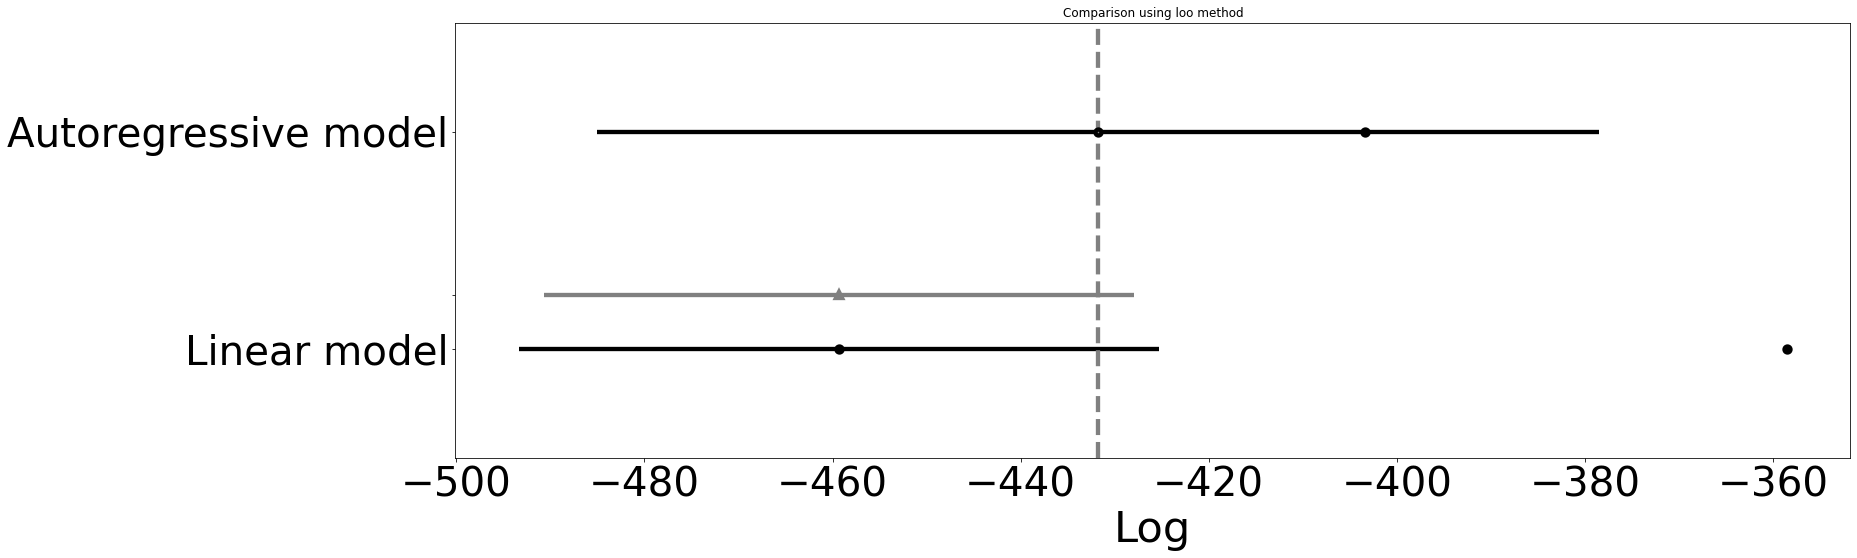

In [33]:
az.plot_compare(az.compare(compare_dict), figsize = (25,8))
plt.title('Comparison using loo method')
plt.show()

In [34]:
az.compare(compare_dict, ic = "waic") 

c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Autoregressive model,0,-431.243989,27.848893,0.000000,0.730538,53.066291,0.000000,True,log
Linear model,1,-458.184262,99.670797,26.940273,0.269462,33.032859,41.504767,True,log


c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less lik

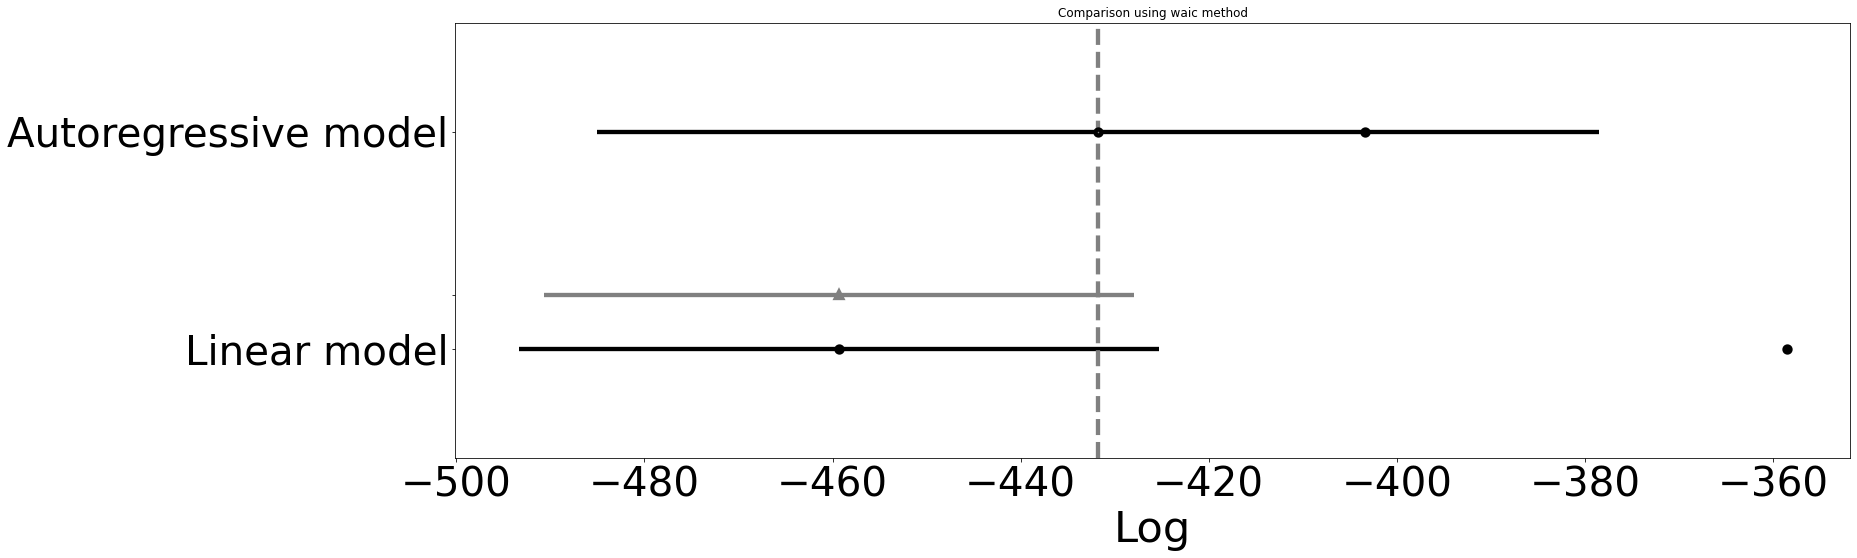

In [35]:
az.plot_compare(az.compare(compare_dict), figsize = (25,8))
plt.title('Comparison using waic method')
plt.show()

<h3>Conclusions</h3>

For predicting data, better overall effects were given by autoregressive model due to its calculations made from previous data rather than seeking linear regression. From historical perspective, and recent pandemic events, it can be seen that previous records are mostly influential for the next months or years as in our models rather than general trends of disease. Autoregressive model tends to be less steep and trend of prediction can be seen from user perspective, where linear regression model seems to be rather worse for predictions in our case.